Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from mesfonctions import scatter_plot
from mesfonctions import arrondi
from mesfonctions import display_scores
from mesfonctions import barh_plot_coefs
from mesfonctions import affichage_tri_r2

from sklearn import set_config
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

In [2]:
# reload d'un élément du module mesfonctions après sa modification
import mesfonctions
from importlib import reload  
mesfonctions = reload(mesfonctions)

## Gestion des paramètres d'affichage de Jupyter

In [3]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 160 sur ma config portable
np.set_printoptions(linewidth=160)

# affichage des objets sklearn
set_config(display='diagram')

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

## Chargement du pickle du df nettoyé, contenant les PropertyUseTypeGFA

In [4]:
df_train = pd.read_pickle('df_train_avec_PropertyUseTypeGFA.pkl')
df_test = pd.read_pickle('df_test_avec_PropertyUseTypeGFA.pkl')

liste_modalites_types_1_2_3 = pickle.load(open('liste_modalites_types_1_2_3.pkl', 'rb'))
liste_variables_PropertyUseTypes_GFA = pickle.load(open('liste_variables_PropertyUseTypes_GFA.pkl', 'rb'))

# Deuxième approche pour TotalGHGEmissions : utilisation des surfaces des PropertyUseType et calcul indirect (via les sources d'énergie) 

## Séparation des variables explicatives et variable à prédire

##### Suppression des lignes pour lesquelles la variable 'TotalGHGEmissions' n'est pas renseignée

In [5]:
df_train = df_train.dropna(subset=['TotalGHGEmissions']).copy()
df_test = df_test.dropna(subset=['TotalGHGEmissions']).copy()

##### Variables explicatives :

In [6]:
X_train_GHG = df_train[liste_variables_PropertyUseTypes_GFA].copy()
X_test_GHG = df_test[liste_variables_PropertyUseTypes_GFA].copy()

##### Variable à prédire :

In [7]:
y_train_GHG = df_train[['ElectricityGHGEmissions', 'SteamUseGHGEmissions', 'NaturalGasGHGEmissions', 'TotalGHGEmissions']].copy()
y_test_GHG = df_test[['ElectricityGHGEmissions', 'SteamUseGHGEmissions', 'NaturalGasGHGEmissions', 'TotalGHGEmissions']].copy()

## Imputation, one-hot encoding, recalibrage

Imputation : non pertinent.  
One-hot encoding : non pertinent car toutes les variables sont quantitatives.  
Recalibrage : non pertinent, on part sur l'hypothèse que l'EnergyUse est proportionnel à la surface.  

## Mise au point d'un scorer qui effectue la somme des émission de CO2 avant de calculer le R²

In [8]:
def my_r2_score(y_true, y_pred):
    
    
    score = r2_score(y_true.iloc[:,0]+y_true.iloc[:,1]+y_true.iloc[:,2], y_pred[:,0]+y_pred[:,1]+y_pred[:,2])
    
    # Affichages des résultats de chaque fold :
#     df = pd.DataFrame() 
#     df["TotalGHGEmissions"] = y_true.iloc[:,0] + y_true.iloc[:,1] + y_true.iloc[:,2]
#     df["Prédiction_ElectricityGHGEmissions"] = y_pred[:,0]
#     df["Prédiction_SteamUseGHGEmissions"] = y_pred[:,1]
#     df["Prédiction_NaturalGasGHGEmissions"] = y_pred[:,2]
#     df["Prédiction_TotalGHGEmissions"] = y_pred[:,0] + y_pred[:,1] + y_pred[:,2]
#     display(df)
#     print("R² = ", arrondi(score), "\n--------------------")

    """ Retourne le R² à partir de la valeur mesurée de 'TotalGHGEmissions' et des prédictions pour cette variables, par la seomme de 'ElectricityGHGEmissions', 'SteamUseGHGEmissions', 'NaturalGasGHGEmissions'.
    Args :
    - y_true : dataframe à 3 colonnes correspondant aux valeurs réelles pour 'ElectricityGHGEmissions', 'SteamUseGHGEmissions', 'NaturalGasGHGEmissions'.
    - y_pred : array numpy à 3 colonnes correspondant aux prédictions pour 'ElectricityGHGEmissions', 'SteamUseGHGEmissions', 'NaturalGasGHGEmissions'.
    Returns : 
    - R² (float)
    """
    
    return score   

In [9]:
my_r2_scorer = make_scorer(my_r2_score)

## Dummy Regressor

In [10]:
moyenne = y_train_GHG.mean()
print("Variables et leurs moyennes :")
print(moyenne)

Variables et leurs moyennes :
ElectricityGHGEmissions     41.516155
SteamUseGHGEmissions        36.744705
NaturalGasGHGEmissions     106.045641
TotalGHGEmissions          184.305847
dtype: float64


In [11]:
ecart_type = y_train_GHG.std()
print("Variables et leurs écarts-types :")
print(ecart_type)

Variables et leurs écarts-types :
ElectricityGHGEmissions    156.212070
SteamUseGHGEmissions       378.424708
NaturalGasGHGEmissions     515.364902
TotalGHGEmissions          733.561296
dtype: float64


In [12]:
zipped = zip(["mean", "median", "quantile", "constant"], [None, None, 0.8, None], [None, None, None, moyenne[0:3]])
for strategy, quantile, constant in zipped:
    print("Stratégie :", strategy)#, "/", quantile, constant)
    dum_reg = DummyRegressor(strategy=strategy, quantile=quantile, constant=constant)
    dum_reg.fit(X_train_GHG, y_train_GHG.iloc[:,0:3])
    GHG_predictions = dum_reg.predict(X_train_GHG)
    print("R² =", r2_score(y_train_GHG.iloc[:,0:3], GHG_predictions, multioutput='raw_values'))

Stratégie : mean
R² = [-2.22044605e-16  2.22044605e-15  7.43849426e-15]
Stratégie : median
R² = [-0.03758783 -0.00943534 -0.02393271]
Stratégie : quantile
R² = [-1.72968539e-06 -9.43533814e-03 -1.22226838e-04]
Stratégie : constant
R² = [-2.22044605e-16  2.22044605e-15  7.43849426e-15]


##### Cross validation - Résultat "brut" de cross_val_score()

In [13]:
dum_reg = DummyRegressor(strategy='mean')

In [14]:
dum_scores = cross_val_score(dum_reg, X_train_GHG, y_train_GHG.iloc[:,0:3],
                             scoring="r2", cv=5)
display_scores(dum_scores, 2)

Scores: -0.00099 -0.00077 -0.0021 -0.0013 -0.0043 
Mean: -0.0019
Standard deviation: 0.0014


Le scoring est de type : multioutput= 'uniform_average'.  Ca ne m'arrange pas. Il faut calculer chaque variable à prédire séparément.

##### Cross validation - Résultats de cross_val_score() sur les différentes variables à prédire :

In [15]:
dum_reg = DummyRegressor(strategy='mean')
dum_scores = cross_val_score(dum_reg, X_train_GHG, y_train_GHG['ElectricityGHGEmissions'],
                             scoring="r2", cv=5)   
display_scores(dum_scores, 2)

Scores: -0.00085 -0.00094 -0.00055 -0.00011 -0.012 
Mean: -0.0029
Standard deviation: 0.0051


In [16]:
dum_scores = cross_val_score(dum_reg, X_train_GHG, y_train_GHG['SteamUseGHGEmissions'],
                             scoring="r2", cv=5)    
display_scores(dum_scores, 2)

Scores: -0.00085 -2.7e-06 -0.005 -0.00027 -6.5e-06 
Mean: -0.0012
Standard deviation: 0.0021


In [17]:
dum_scores = cross_val_score(dum_reg, X_train_GHG, y_train_GHG['NaturalGasGHGEmissions'],
                             scoring="r2", cv=5)    
display_scores(dum_scores, 2)

Scores: -0.0013 -0.0014 -0.00067 -0.0035 -0.00095 
Mean: -0.0015
Standard deviation: 0.0011


##### Cross validation sur la variable 'TotalGHGEmissions' avec my_r2_scorer

In [18]:
dum_scores = cross_val_score(dum_reg, X_train_GHG, y_train_GHG.iloc[:, 0:3], scoring=my_r2_scorer, cv=5)
display_scores(dum_scores)

Scores: -0.000221 -0.0011 -0.000135 -0.000848 -0.000933 
Mean: -0.000647
Standard deviation: 0.000438


##### Prédiction sur y_test

In [19]:
dum_reg.fit(X_train_GHG, y_train_GHG.iloc[:,0:3])
GHG_predictions = dum_reg.predict(X_test_GHG)
print("R² =", r2_score(y_test_GHG.iloc[:,0:3], GHG_predictions, multioutput='raw_values'))

R² = [-0.00128573 -0.00065633 -0.00013847]


## Régression linéaire simple

### Test monocolonne (ElectricityGHGEmissions)

In [20]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_GHG, y_train_GHG.ElectricityGHGEmissions)

LinearRegression()

In [21]:
lin_reg.intercept_

-1.2334295599193723

In [22]:
# Test de quelques valeurs prédites
some_data = X_train_GHG.iloc[:100]
some_labels = y_train_GHG[['ElectricityGHGEmissions']].iloc[:100].copy()
some_data_predicted = lin_reg.predict(some_data)

some_labels['Prédictions'] = some_data_predicted
some_labels

,ElectricityGHGEmissions,Prédictions
2447,2.347607,10.054493
2559,1.469326,0.889143
137,57.200983,50.803129
1969,2.883748,2.840942
446,1.817032,12.331960
1519,43.413251,22.899775
3317,118.187952,122.006429
1197,4.729517,7.609847
530,49.233423,31.815814
245,168.882870,117.349768


### Multicolonne

In [23]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_GHG, y_train_GHG.iloc[:,0:3])

LinearRegression()

In [24]:
df = y_train_GHG.copy()
GHG_predictions = lin_reg.predict(X_train_GHG)

df['Prédictions_ElectricityGHGEmissions'] = GHG_predictions[:,0]
df['Prédictions_SteamUseGHGEmissions'] = GHG_predictions[:,1]
df['Prédictions_NaturalGasGHGEmissions'] = GHG_predictions[:,2]   

df['Prédictions_TotalGHGEmissions'] = GHG_predictions[:,0] + GHG_predictions[:,1] + GHG_predictions[:,2]
# df['TotalGHGEmissions'] = Z_train_GHG['TotalGHGEmissions'].copy()
df.head(100)

,ElectricityGHGEmissions,SteamUseGHGEmissions,NaturalGasGHGEmissions,TotalGHGEmissions,Prédictions_ElectricityGHGEmissions,Prédictions_SteamUseGHGEmissions,Prédictions_NaturalGasGHGEmissions,Prédictions_TotalGHGEmissions
2447,2.347607,0.000000,0.000000,2.35,10.054493,-3.814422,6.755904,12.995975
2559,1.469326,0.000000,53.593301,55.06,0.889143,-7.905173,1.159199,-5.856831
137,57.200983,0.000000,215.652943,272.85,50.803129,16.554946,390.887111,458.245186
1969,2.883748,0.000000,18.612081,21.50,2.840942,-12.064908,36.235442,27.011476
446,1.817032,0.000000,23.924993,25.74,12.331960,-0.471699,47.854955,59.715216
1519,43.413251,0.000000,165.116759,208.53,22.899775,-3.736373,76.673005,95.836407
3317,118.187952,0.000000,96.004557,214.19,122.006429,-26.951466,80.205511,175.260474
1197,4.729517,0.000000,28.128012,32.86,7.609847,-5.259815,34.142829,36.492861
530,49.233423,0.000000,70.231867,119.46,31.815814,-18.546137,235.777077,249.046754
245,168.882870,0.000000,0.000000,168.88,117.349768,20.401705,41.116201,178.867674


### Metrics

##### RMSE :

In [25]:
lin_mse = mean_squared_error(y_train_GHG.iloc[:,0:3], GHG_predictions, multioutput='raw_values')
lin_rmse = np.sqrt(lin_mse)
arrondi(lin_rmse)

[31.5, 187, 301]

##### MAE :

In [26]:
lin_mae = mean_absolute_error(y_train_GHG.iloc[:,0:3], GHG_predictions, multioutput='raw_values')
arrondi(lin_mae)

[12.7, 45.8, 102]

##### R² :

R² pour les 3 types d'émissions pris séparément :

In [27]:
arrondi(r2_score(y_train_GHG.iloc[:,0:3], GHG_predictions, multioutput='raw_values'))

[0.959, 0.756, 0.658]

R² pour les 3 types d'émissions sommés :

In [28]:
arrondi(r2_score(y_train_GHG['TotalGHGEmissions'], GHG_predictions[:,0] + GHG_predictions[:,1] + GHG_predictions[:,2]))

0.883

On retrouve la même valeur que pour le modèle de régression linéaire du notebook "calcul direct".

### Cross validation

In [29]:
lin_scores = cross_val_score(lin_reg, X_train_GHG, y_train_GHG.iloc[:, 0:3], scoring=my_r2_scorer, cv=5)
display_scores(lin_scores)

Scores: 0.575 0.406 0.495 0.124 0.781 
Mean: 0.476
Standard deviation: 0.241


### Généralisation du modèle sur y_test

In [30]:
GHG_predictions = lin_reg.predict(X_test_GHG)
arrondi(my_r2_score(y_test_GHG.iloc[:, 0:3], GHG_predictions))

0.888

On retrouve la même valeur que pour le modèle de régression linéaire du notebook "calcul direct".

##### Scatter plot

In [31]:
# ser_predictions = pd.Series(GHG_predictions[:,0]+GHG_predictions[:,1]+GHG_predictions[:,2], name='Prédictions')
# scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,4], ser_y=ser_predictions, alpha=1, droite_identite=True)
# scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,4], ser_y=ser_predictions, alpha=1, max_x=2000, max_y=2000, droite_identite=True)

### Analyse des paramètres du modèle

In [32]:
arrondi(lin_reg.intercept_)

[-1.23, -8.95, -15.4]

In [33]:
arrondi(lin_reg.intercept_.sum())

-25.6

En faisant la somme, on retrouve le même intercept que pour le modèle basé sur le calcul direct de TotalGHGEmissions.

In [34]:
print("lin_reg.coef_ shape :", lin_reg.coef_.shape)
coefs = lin_reg.coef_

lin_reg.coef_ shape : (3, 64)


In [35]:
coefs

array([[ 3.39617911e-04,  1.00017849e-04,  1.41448280e-04,  3.05574517e-04,  6.22952090e-04,  3.64303331e-04,  1.09307745e-04,  1.60914448e-04,
         8.26083540e-04,  5.20599513e-04,  4.37240368e-06,  8.06509009e-05,  1.71189520e-04,  4.81563785e-04,  2.92858159e-04,  2.36728787e-04,
         2.13013946e-04,  1.13462459e-03,  8.07075373e-04,  3.21709260e-04,  5.89083398e-04,  9.45598048e-04,  7.61149484e-04,  7.86862929e-04,
         2.46801670e-04,  5.24774697e-04,  1.99146122e-04,  5.09570470e-04,  2.92591433e-04,  4.06583436e-04, -3.88306888e-05,  8.71935017e-04,
         2.72490724e-04,  4.62477264e-04,  4.54572053e-04,  2.67479971e-04,  7.50215275e-03,  1.96997830e-03,  2.48880361e-04,  8.73934442e-04,
         4.01509878e-04,  3.43298389e-04,  5.46076761e-04,  2.75282983e-04,  4.64213981e-04,  2.00788566e-04,  3.87388390e-04,  3.35921997e-04,
         6.70298469e-04,  5.92402356e-04,  5.04851266e-04,  5.17486930e-04,  5.60151941e-04,  3.18427132e-04,  2.16840434e-18, -5.240315

In [36]:
liste_effectif = []
for moda in liste_modalites_types_1_2_3:
    effectif = len(df_train[moda+' GFA'][df_train[moda+' GFA']!=0])
    liste_effectif.append(effectif)
df_coefs = pd.DataFrame(liste_effectif, columns=['Effectif'], index=liste_modalites_types_1_2_3)

In [37]:
df_coefs['Coef NR LR Elec'] = coefs[0].T       # Prédictions_ElectricityGHGEmissions	Prédictions_SteamUseGHGEmissions	Prédictions_NaturalGasGHGEmissions
df_coefs['Coef NR LR Steam'] = coefs[1].T
df_coefs['Coef NR LR Gas'] = coefs[2].T
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef NR LR Elec', ascending=False))

,Effectif,Coef NR LR Elec,Coef NR LR Steam,Coef NR LR Gas
Data Center,20,7.5e-03,-6.5e-05,3.9e-05
Urgent Care/Clinic/Other Outpatient,2,2.0e-03,2.7e-03,3.1e-03
Food Sales,2,1.2e-03,2.9e-03,1.0e-02
Laboratory,21,1.1e-03,7.6e-04,1.7e-02
Social/Meeting Hall,17,9.5e-04,5.9e-03,2.4e-03
Other/Specialty Hospital,3,8.7e-04,-1.8e-03,2.0e-02
Other - Services,14,8.7e-04,2.0e-04,9.4e-04
Supermarket/Grocery Store,45,8.3e-04,1.8e-04,3.2e-03
Refrigerated Warehouse,15,8.1e-04,4.1e-04,-3.5e-03
Manufacturing/Industrial Plant,8,7.9e-04,3.1e-04,4.7e-03


On observe qques coefs négatifs (aberrants) mais il sont "proches" de 0.

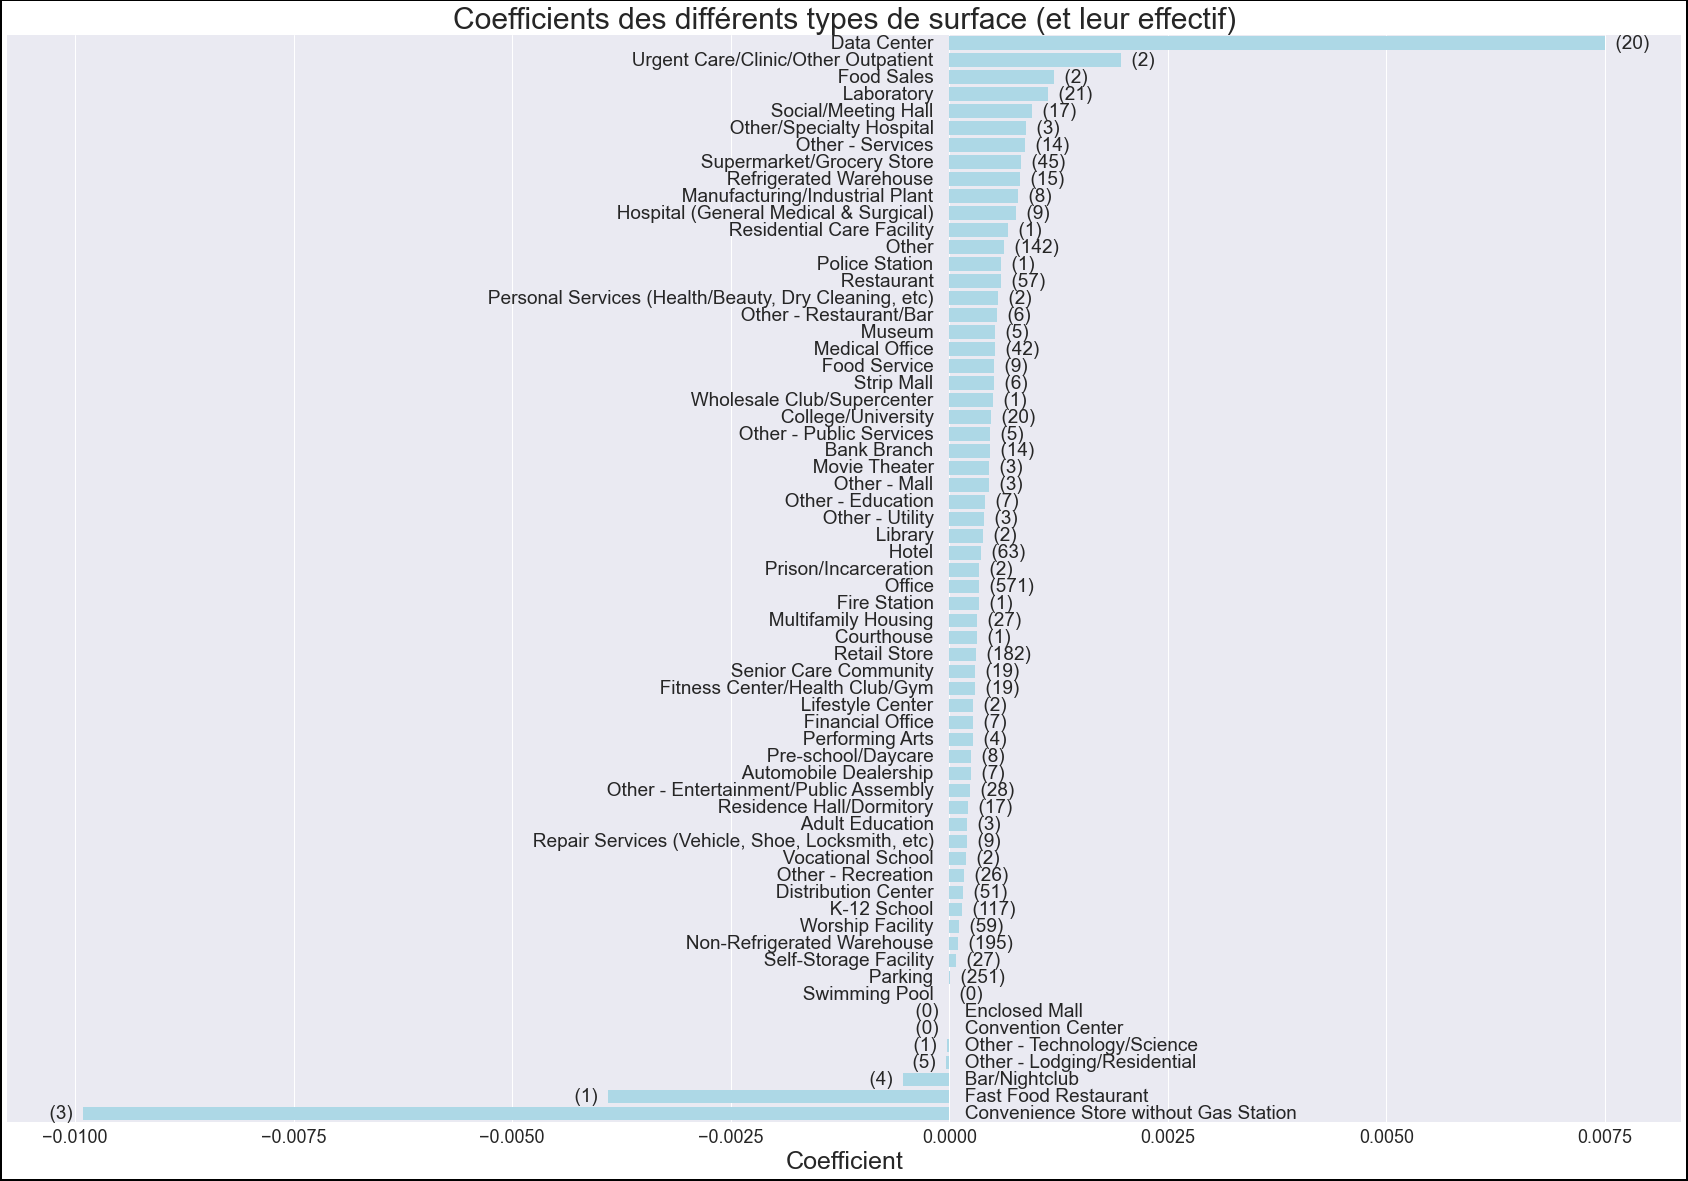

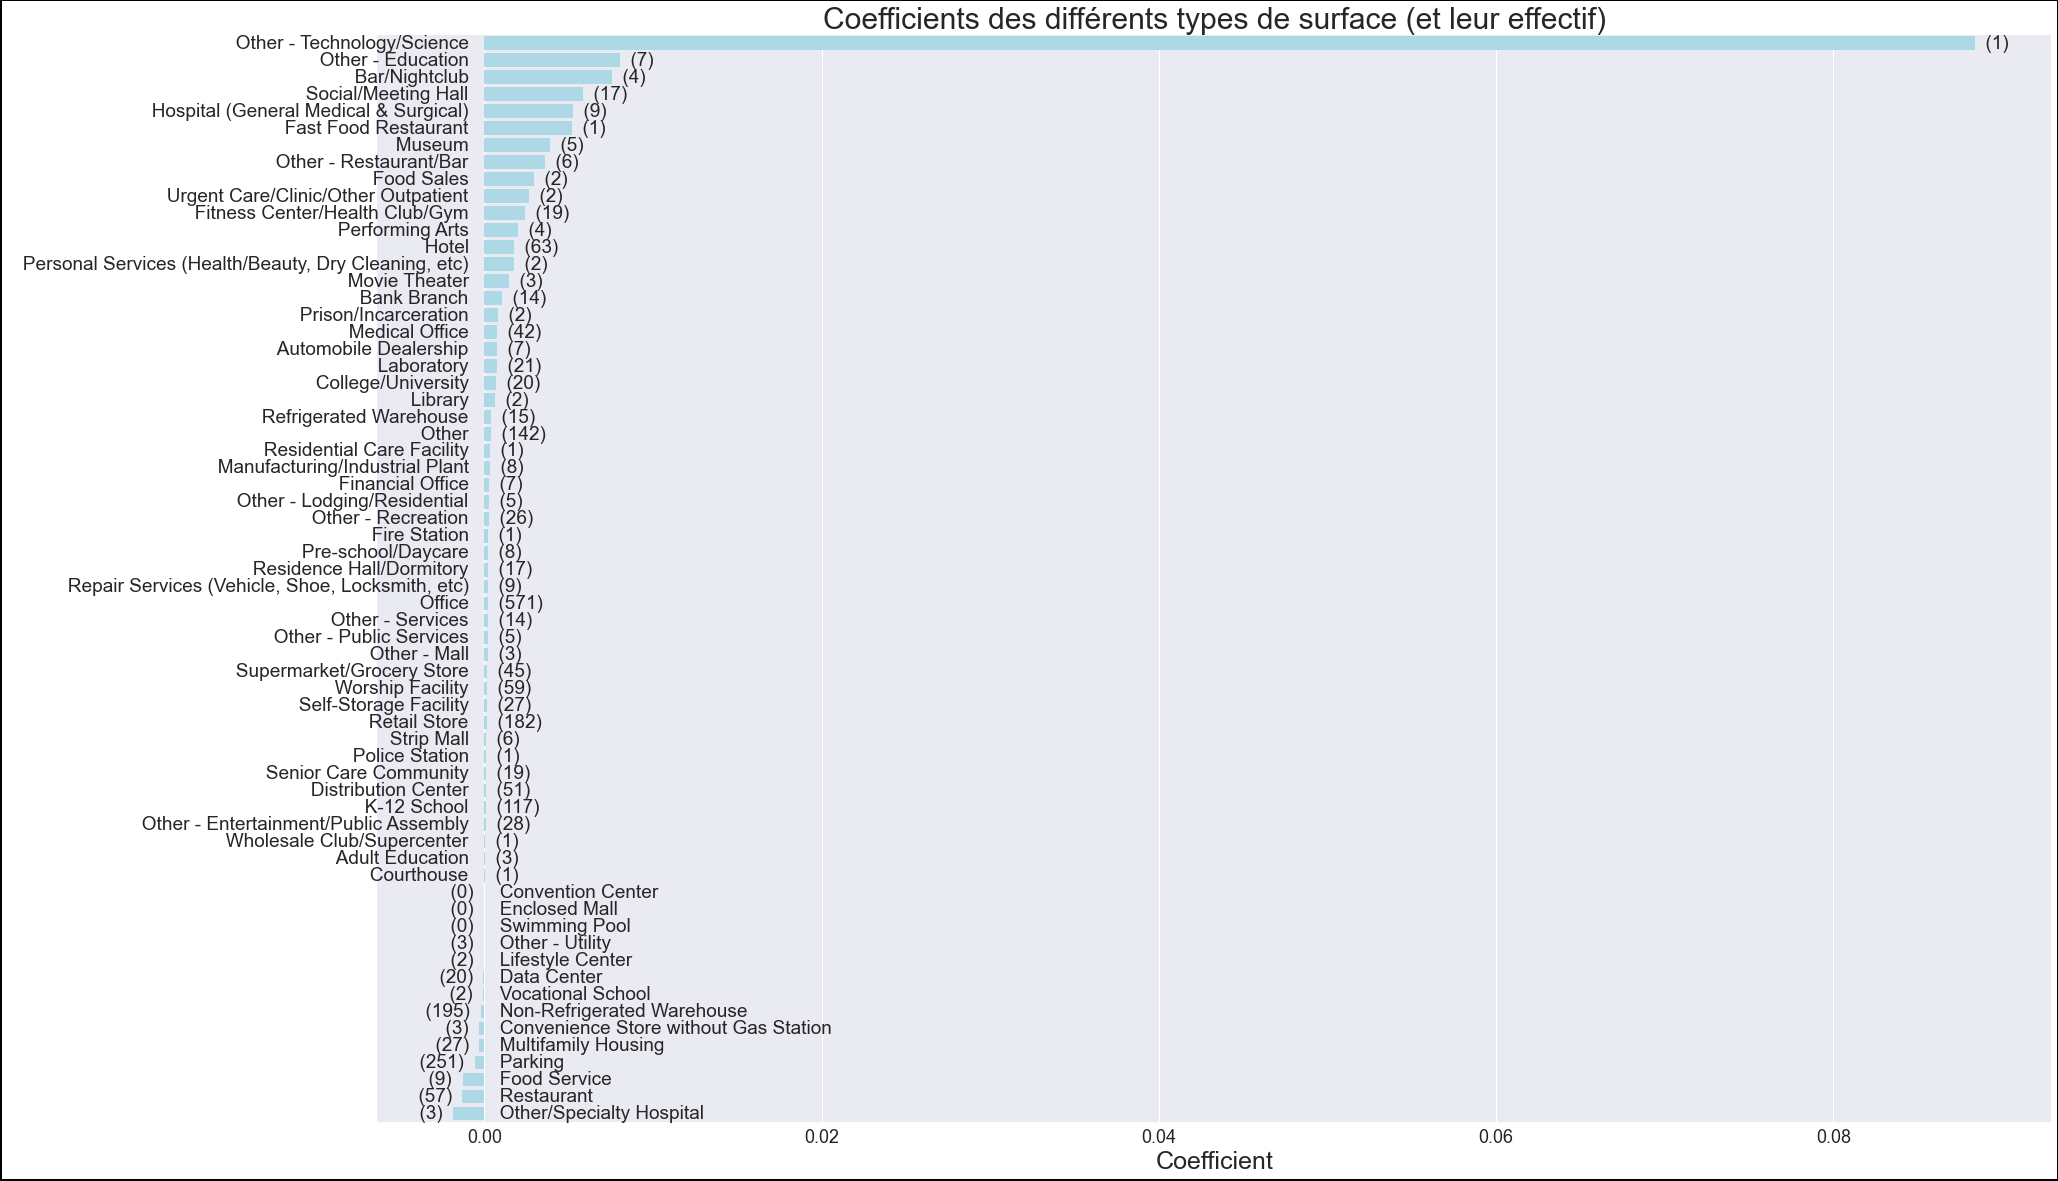

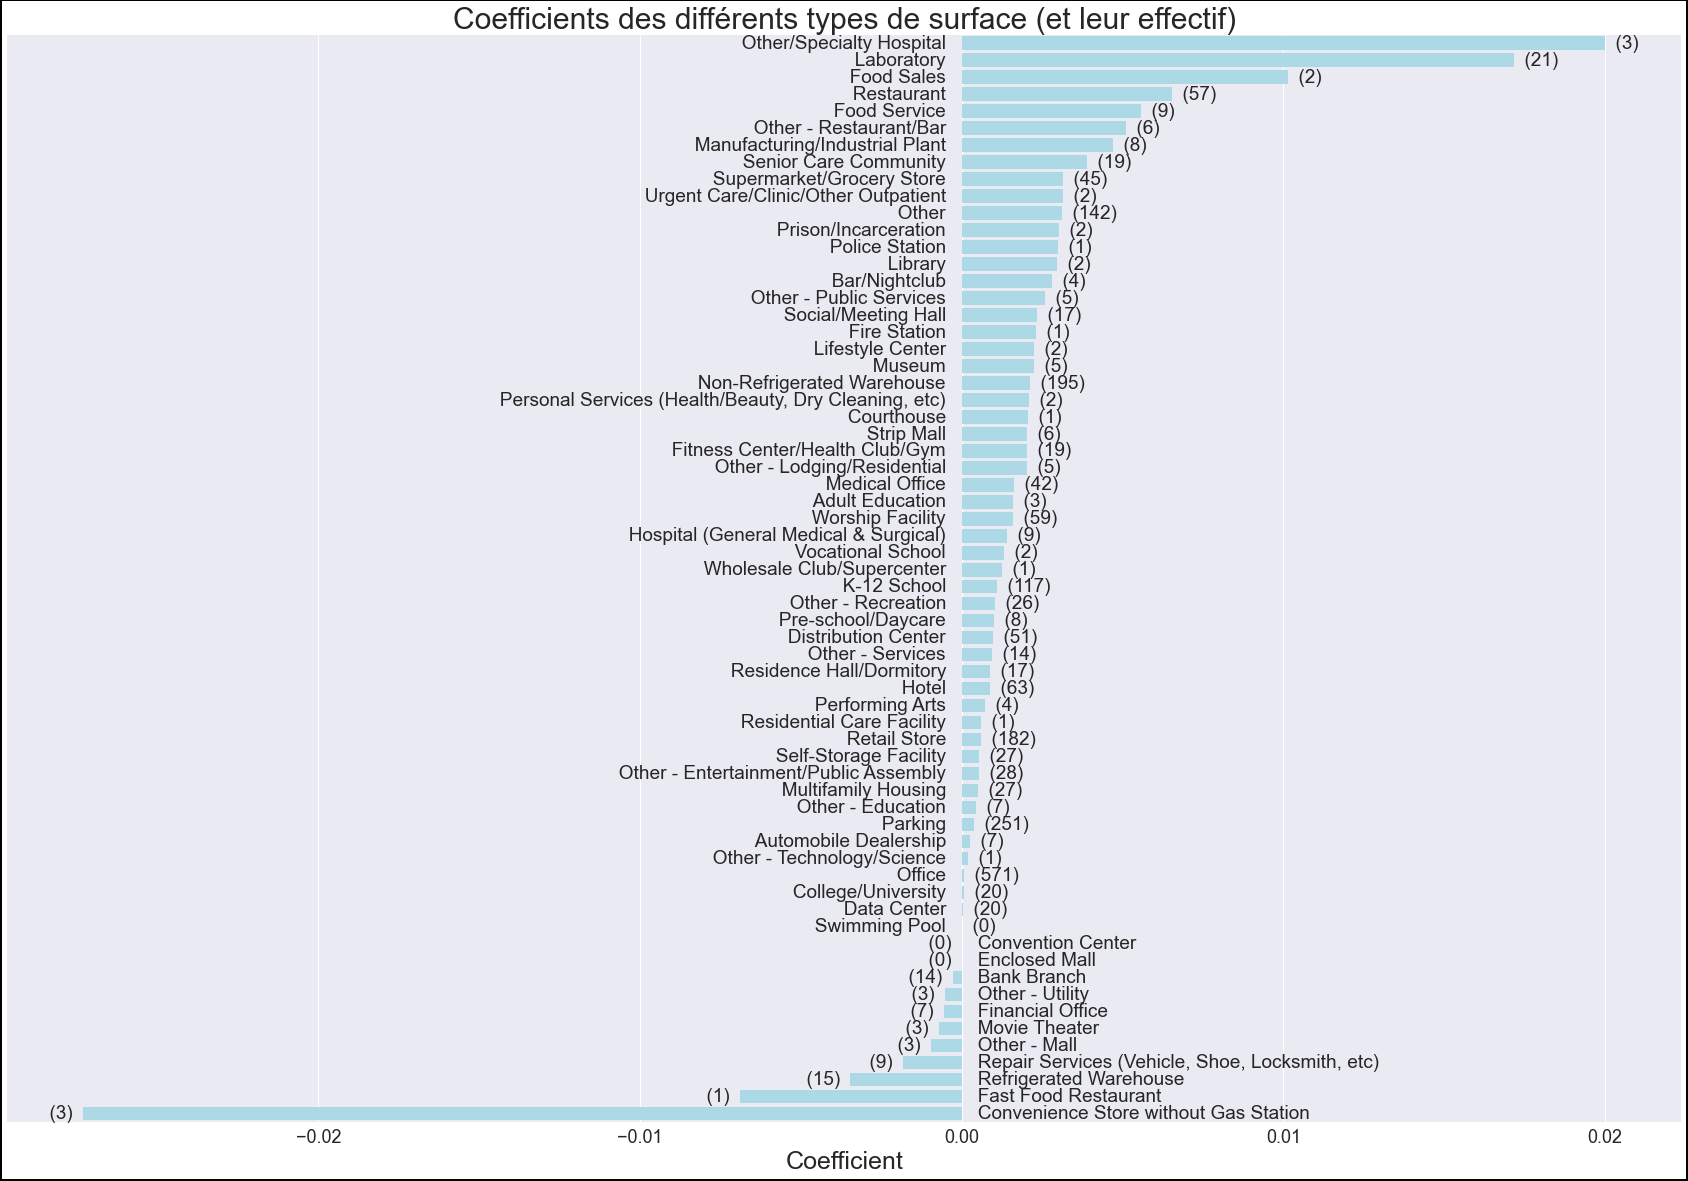

In [38]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef NR LR Elec', ascending=True).iloc[:, 1], effectif_array=df_coefs.sort_values(by='Coef NR LR Elec', ascending=True).iloc[:, 0])
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef NR LR Steam', ascending=True).iloc[:, 2], effectif_array=df_coefs.sort_values(by='Coef NR LR Steam', ascending=True).iloc[:, 0])
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef NR LR Gas', ascending=True).iloc[:, 3], effectif_array=df_coefs.sort_values(by='Coef NR LR Gas', ascending=True).iloc[:, 0])

## Recalibrage des variables

### Transformation = StandardScaler

In [39]:
ss = StandardScaler()
X_train_GHG_ss = ss.fit_transform(X_train_GHG)
X_test_GHG_ss = ss.transform(X_test_GHG)

##### Régression linéaire simple :

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 0:3])
GHG_predictions = lin_reg.predict(X_train_GHG_ss)
print("R² =", arrondi(my_r2_score(y_train_GHG.iloc[:, 0:3], GHG_predictions)))

R² = 0.883


Comme attendu, on retrouve le même R² que pour la régression linéaire simple sans scaler, car le scaler fait une transformation linéaire.

In [41]:
arrondi(lin_reg.intercept_)

[41.5, 36.7, 106]

In [42]:
lin_reg.coef_

array([[ 4.10564105e+01,  3.34754762e+00,  4.06772447e+00,  8.12462503e+00,  1.77360117e+01,  1.47667703e+01,  8.43451266e-01,  2.19556664e+00,
         7.66828619e+00,  1.15582747e+01,  2.10214779e-01,  5.52618301e-01,  2.73177265e+00,  1.25973885e+02,  3.90052479e+00,  1.29777767e+01,
         2.35039175e+00,  2.41009537e+01,  6.99486761e+00,  4.57629715e+00,  2.54670549e+00,  2.20443087e+00,  3.98578001e+01,  1.36738918e+00,
         1.03264575e+00,  1.31333650e+00,  5.47036512e-01,  2.70302445e+00,  9.99555084e-01,  7.02403770e-01, -6.86350976e-02,  3.43641833e+00,
         2.51204824e+00,  5.42981974e-01,  7.01263795e+00,  5.23346196e-01,  5.26731057e+01,  8.82655866e+00,  4.14303191e-01,  1.90135141e+00,
         1.56804366e+00,  1.52860115e-01,  5.99461626e-01,  2.48451029e+00,  8.86679854e-01,  3.79998728e-01,  2.09425882e-01,  3.58671851e-01,
         4.69734174e-01,  1.44294739e+00,  2.00416780e+00,  4.43825577e-01,  4.09995466e-01,  4.69007407e+00,  2.13162821e-14, -2.347088

## Ridge regression

### Variables non recalibrées ; alpha unique pour les 3 énergies

In [43]:
ridge_nr = RidgeCV(alphas=np.logspace(10, 14, 100), cv=5, scoring=my_r2_scorer)   
ridge_nr.fit(X_train_GHG, y_train_GHG.iloc[:, 0:3])

RidgeCV(alphas=array([1.00000000e+10, 1.09749877e+10, 1.20450354e+10, 1.32194115e+10, 1.45082878e+10, 1.59228279e+10, 1.74752840e+10, 1.91791026e+10, 2.10490414e+10,
       2.31012970e+10, 2.53536449e+10, 2.78255940e+10, 3.05385551e+10, 3.35160265e+10, 3.67837977e+10, 4.03701726e+10, 4.43062146e+10, 4.86260158e+10,
       5.33669923e+10, 5.85702082e+10, 6.42807312e+10, 7.05480231e+1...
       8.11130831e+12, 8.90215085e+12, 9.77009957e+12, 1.07226722e+13, 1.17681195e+13, 1.29154967e+13, 1.41747416e+13, 1.55567614e+13, 1.70735265e+13,
       1.87381742e+13, 2.05651231e+13, 2.25701972e+13, 2.47707636e+13, 2.71858824e+13, 2.98364724e+13, 3.27454916e+13, 3.59381366e+13, 3.94420606e+13,
       4.32876128e+13, 4.75081016e+13, 5.21400829e+13, 5.72236766e+13, 6.28029144e+13, 6.89261210e+13, 7.56463328e+13, 8.30217568e+13, 9.11162756e+13,
       1.00000000e+14]),
        cv=5, scoring=make_scorer(my_r2_score))

In [44]:
best_alpha = ridge_nr.alpha_
arrondi(best_alpha, puissance10=9)

'376.49e9'

In [45]:
arrondi(ridge_nr.intercept_)

[9.68, 2.63, 23.7]

In [46]:
# R² CV
arrondi(ridge_nr.best_score_)

0.575

In [47]:
print(ridge_nr.coef_.shape)
ridge_nr.coef_

(3, 64)


array([[ 3.32453851e-04,  1.72449613e-04,  4.38871731e-05,  1.72014753e-04,  4.22255488e-04,  2.82406054e-04, -2.49867050e-05,  2.82231191e-05,
         1.58999523e-04,  3.05862082e-04,  8.10088970e-05, -1.53027191e-05,  6.67822488e-05,  4.77437672e-04,  8.40717558e-05,  2.11541293e-04,
         3.96234160e-05,  6.50201927e-04,  1.29902346e-04,  1.05526665e-04,  5.18750576e-05,  1.15231836e-05,  6.65229895e-04,  4.01485225e-06,
        -2.35515757e-07,  6.04645479e-06,  6.13779193e-06,  3.66770450e-05,  1.80748820e-07,  8.54621046e-07, -3.81014078e-06,  3.28977204e-05,
         3.57916528e-05, -1.41456351e-06,  2.35039067e-04,  2.76551431e-07,  1.10168909e-03,  1.25147234e-04, -7.01775878e-07,  2.32786470e-05,
         1.70538465e-05, -4.25031361e-07,  1.97403475e-06,  5.53293038e-05,  3.01441460e-06, -3.82169813e-07, -3.01969293e-07,  2.23023948e-07,
         4.21181551e-07,  9.63851534e-06,  2.26477693e-05, -7.92451707e-07, -7.42648182e-09,  1.29337658e-04,  0.00000000e+00, -9.092163

##### Prédiction sur y_test

In [48]:
ridge_nr = Ridge(alpha=best_alpha)
ridge_nr.fit(X_train_GHG, y_train_GHG.iloc[:, 0:3])
GHG_predictions = ridge_nr.predict(X_test_GHG)
my_r2_score(y_test_GHG.iloc[:, 0:3], GHG_predictions)

0.9309194680681148

On obtient exactement le même résultat que pour le Ridge du notebook précédent (calcul direct).  
Il faut répéter les opérations réalisées en séparant les régressions pour les 3 types d'émission de GHG.

### Variables non recalibrées ; alpha différent pour chacune des 3 énergies

#### Energie = Elec

In [49]:
ridge_nr_elec = RidgeCV(alphas=np.logspace(8, 12, 100), cv=5, scoring="r2")   
ridge_nr_elec.fit(X_train_GHG, y_train_GHG.iloc[:, 0])

RidgeCV(alphas=array([1.00000000e+08, 1.09749877e+08, 1.20450354e+08, 1.32194115e+08, 1.45082878e+08, 1.59228279e+08, 1.74752840e+08, 1.91791026e+08, 2.10490414e+08,
       2.31012970e+08, 2.53536449e+08, 2.78255940e+08, 3.05385551e+08, 3.35160265e+08, 3.67837977e+08, 4.03701726e+08, 4.43062146e+08, 4.86260158e+08,
       5.33669923e+08, 5.85702082e+08, 6.42807312e+08, 7.05480231e+0...
       8.11130831e+10, 8.90215085e+10, 9.77009957e+10, 1.07226722e+11, 1.17681195e+11, 1.29154967e+11, 1.41747416e+11, 1.55567614e+11, 1.70735265e+11,
       1.87381742e+11, 2.05651231e+11, 2.25701972e+11, 2.47707636e+11, 2.71858824e+11, 2.98364724e+11, 3.27454916e+11, 3.59381366e+11, 3.94420606e+11,
       4.32876128e+11, 4.75081016e+11, 5.21400829e+11, 5.72236766e+11, 6.28029144e+11, 6.89261210e+11, 7.56463328e+11, 8.30217568e+11, 9.11162756e+11,
       1.00000000e+12]),
        cv=5, scoring='r2')

In [50]:
best_alpha = ridge_nr_elec.alpha_
arrondi(best_alpha, puissance10=6)

'849.75e6'

In [51]:
arrondi(ridge_nr_elec.intercept_)

-0.869

In [52]:
# R² CV
arrondi(ridge_nr_elec.best_score_)

0.759

In [53]:
print(ridge_nr_elec.coef_.shape)
ridge_nr_elec.coef_

(64,)


array([ 3.37333375e-04,  1.00573259e-04,  1.38587441e-04,  3.04416885e-04,  6.21500896e-04,  3.63207717e-04,  1.01043812e-04,  1.57217539e-04,  8.14621690e-04,
        5.23415535e-04,  4.74612582e-06,  7.49944708e-05,  1.70194073e-04,  4.81500747e-04,  2.89715609e-04,  2.36433883e-04,  2.09231996e-04,  1.13275028e-03,
        7.97540322e-04,  3.19557915e-04,  5.74623885e-04,  8.37344600e-04,  7.60465370e-04,  6.40075007e-04,  2.32344348e-04,  4.66543153e-04,  1.79734072e-04,
        4.95750292e-04,  2.71893914e-04,  3.32219637e-04, -2.92082817e-05,  8.32257505e-04,  2.75571490e-04,  3.04228459e-04,  4.54764795e-04,  2.25954224e-04,
        7.40578303e-03,  1.90662496e-03,  1.96716753e-04,  7.51357380e-04,  3.82783263e-04,  7.38372613e-05,  3.57478663e-04,  2.71642752e-04,  3.88564341e-04,
        1.69423201e-04,  1.14963576e-04,  2.09281677e-04,  2.85116495e-04,  5.31108049e-04,  4.82763960e-04,  2.44485205e-04,  2.26725968e-04,  3.16816125e-04,
        0.00000000e+00, -1.03163365e-04,

Prédiction sur y_test

In [54]:
ridge_nr_elec = Ridge(alpha=best_alpha)
ridge_nr_elec.fit(X_train_GHG, y_train_GHG.iloc[:, 0])
print("R² = ", arrondi(ridge_nr_elec.score(X_test_GHG, y_test_GHG.iloc[:,0])))
GHG_predictions_elec = ridge_nr_elec.predict(X_test_GHG)

R² =  0.857


#### Energie = Steam

In [55]:
ridge_nr_steam = RidgeCV(alphas=np.logspace(10, 14, 100), cv=5, scoring="r2")   
ridge_nr_steam.fit(X_train_GHG, y_train_GHG.iloc[:, 1])

RidgeCV(alphas=array([1.00000000e+10, 1.09749877e+10, 1.20450354e+10, 1.32194115e+10, 1.45082878e+10, 1.59228279e+10, 1.74752840e+10, 1.91791026e+10, 2.10490414e+10,
       2.31012970e+10, 2.53536449e+10, 2.78255940e+10, 3.05385551e+10, 3.35160265e+10, 3.67837977e+10, 4.03701726e+10, 4.43062146e+10, 4.86260158e+10,
       5.33669923e+10, 5.85702082e+10, 6.42807312e+10, 7.05480231e+1...
       8.11130831e+12, 8.90215085e+12, 9.77009957e+12, 1.07226722e+13, 1.17681195e+13, 1.29154967e+13, 1.41747416e+13, 1.55567614e+13, 1.70735265e+13,
       1.87381742e+13, 2.05651231e+13, 2.25701972e+13, 2.47707636e+13, 2.71858824e+13, 2.98364724e+13, 3.27454916e+13, 3.59381366e+13, 3.94420606e+13,
       4.32876128e+13, 4.75081016e+13, 5.21400829e+13, 5.72236766e+13, 6.28029144e+13, 6.89261210e+13, 7.56463328e+13, 8.30217568e+13, 9.11162756e+13,
       1.00000000e+14]),
        cv=5, scoring='r2')

In [56]:
best_alpha = ridge_nr_steam.alpha_
arrondi(best_alpha, puissance10=9)

'215.44e9'

In [57]:
arrondi(ridge_nr_steam.intercept_)

0.93

In [58]:
# R²
arrondi(ridge_nr_steam.best_score_)

0.346

In [59]:
print(ridge_nr_steam.coef_.shape)
ridge_nr_steam.coef_

(64,)


array([ 1.30373949e-04, -1.51186286e-04, -4.44216420e-06,  4.46643452e-05,  2.61405051e-04,  1.53376717e-03,  1.77799353e-05, -2.01922714e-06,  3.85997394e-06,
        4.18520927e-04, -3.35109178e-04, -3.69378874e-06,  1.49668436e-04,  6.76841807e-04,  4.82413105e-06,  5.60499962e-05,  5.60293538e-05,  5.28344491e-04,
        7.22350827e-05, -2.38387668e-04, -1.04135057e-04,  1.83633056e-04,  4.88422680e-03, -6.73456848e-07,  3.37210031e-05,  1.39124832e-04, -1.01975370e-05,
        4.38654338e-06,  1.41139601e-04,  1.42638947e-04, -1.64836191e-06,  2.88758452e-07,  6.02757129e-05,  1.92972862e-06,  1.95397341e-06,  4.62171468e-05,
       -2.47082093e-05,  2.85144420e-04, -6.44599717e-07, -3.06272374e-05, -5.84391576e-06, -9.90475043e-08,  3.10088133e-05, -9.35799777e-06, -5.23418783e-07,
       -2.09908644e-06, -1.19893232e-07, -1.66937228e-07, -1.10004230e-07, -3.69957520e-07, -5.69626345e-07, -8.38126351e-06,  7.54070227e-06, -9.91368932e-07,
        0.00000000e+00,  9.91809463e-06,

Prédiction sur y_test

In [60]:
ridge_nr_steam = Ridge(alpha=best_alpha)
ridge_nr_steam.fit(X_train_GHG, y_train_GHG.iloc[:, 1])
print("R² = ", arrondi(ridge_nr_steam.score(X_test_GHG, y_test_GHG.iloc[:,1])))
GHG_predictions_steam = ridge_nr_steam.predict(X_test_GHG)

R² =  0.745


#### Energie = Gas

In [61]:
ridge_nr_gas = RidgeCV(alphas=np.logspace(13, 17, 100), cv=5, scoring="r2")   
ridge_nr_gas.fit(X_train_GHG, y_train_GHG.iloc[:, 2])

RidgeCV(alphas=array([1.00000000e+13, 1.09749877e+13, 1.20450354e+13, 1.32194115e+13, 1.45082878e+13, 1.59228279e+13, 1.74752840e+13, 1.91791026e+13, 2.10490414e+13,
       2.31012970e+13, 2.53536449e+13, 2.78255940e+13, 3.05385551e+13, 3.35160265e+13, 3.67837977e+13, 4.03701726e+13, 4.43062146e+13, 4.86260158e+13,
       5.33669923e+13, 5.85702082e+13, 6.42807312e+13, 7.05480231e+1...
       8.11130831e+15, 8.90215085e+15, 9.77009957e+15, 1.07226722e+16, 1.17681195e+16, 1.29154967e+16, 1.41747416e+16, 1.55567614e+16, 1.70735265e+16,
       1.87381742e+16, 2.05651231e+16, 2.25701972e+16, 2.47707636e+16, 2.71858824e+16, 2.98364724e+16, 3.27454916e+16, 3.59381366e+16, 3.94420606e+16,
       4.32876128e+16, 4.75081016e+16, 5.21400829e+16, 5.72236766e+16, 6.28029144e+16, 6.89261210e+16, 7.56463328e+16, 8.30217568e+16, 9.11162756e+16,
       1.00000000e+17]),
        cv=5, scoring='r2')

In [62]:
best_alpha = ridge_nr_gas.alpha_
arrondi(best_alpha, puissance10=9)

'259502.42e9'

In [63]:
arrondi(ridge_nr_gas.intercept_)

104

In [64]:
# R²
arrondi(ridge_nr_gas.best_score_)

-0.000964

In [65]:
print(ridge_nr_gas.coef_.shape)
ridge_nr_gas.coef_

(64,)


array([ 3.65482011e-05,  2.55800813e-05,  8.67671351e-07,  6.43859295e-07,  1.09024186e-05,  5.20973708e-06, -3.64314603e-07, -1.51991629e-07,  6.06595914e-07,
        5.37102329e-06,  1.44424771e-05, -3.64349979e-07,  8.85670201e-07,  1.67263670e-05,  2.86726411e-06,  6.37880059e-06, -1.13295177e-08,  4.13985774e-05,
       -2.30859318e-07,  6.78957727e-07,  4.21563489e-07, -3.78878904e-08,  1.86343707e-05,  4.27040367e-09, -1.06239661e-07, -1.30409638e-08, -1.22789095e-08,
        1.29626020e-07, -2.09499745e-08, -3.48628549e-08, -2.21442089e-08, -1.38208067e-08, -2.58590104e-07, -5.00990963e-08, -2.04463482e-07, -4.60427015e-08,
       -2.03946497e-07,  2.32849770e-07, -2.80113805e-08,  6.22490954e-07, -4.28805485e-08, -7.48408773e-09,  5.38464191e-09,  7.93784935e-07,  3.17687167e-09,
       -2.09964167e-08, -8.17820552e-09, -4.43745826e-09, -1.02169712e-08,  5.02087845e-08,  3.44699290e-08,  1.20407930e-09, -8.48511052e-09,  2.05054195e-06,
        0.00000000e+00, -8.91511025e-09,

Prédiction sur y_test

In [66]:
ridge_nr_gas = Ridge(alpha=best_alpha)
ridge_nr_gas.fit(X_train_GHG, y_train_GHG.iloc[:, 2])
print("R² = ", arrondi(ridge_nr_gas.score(X_test_GHG, y_test_GHG.iloc[:,2])))
GHG_predictions_gas = ridge_nr_gas.predict(X_test_GHG)

R² =  0.00504


#### Somme des émissions

In [67]:
    df = pd.DataFrame() 
    df["TotalGHGEmissions"] = y_test_GHG.iloc[:, 3]
    df["GHGEmissions_elec"] = y_test_GHG.iloc[:, 0]
    df["Prédiction_GHGEmissions_elec"] = GHG_predictions_elec
    df["GHGEmissions_steam"] = y_test_GHG.iloc[:, 1]
    df["Prédiction_GHGEmissions_steam"] = GHG_predictions_steam
    df["GHGEmissions_gas"] = y_test_GHG.iloc[:, 2]
    df["Prédiction_GHGEmissions_gas"] = GHG_predictions_gas
    df["Prédiction_TotalGHGEmissions"] = GHG_predictions_elec + GHG_predictions_steam + GHG_predictions_gas
    
    print("R² (généralisation sur y_test) = ", arrondi(r2_score(df['TotalGHGEmissions'], df["Prédiction_TotalGHGEmissions"])))
    display(df)

R² (généralisation sur y_test) =  0.889


,TotalGHGEmissions,GHGEmissions_elec,Prédiction_GHGEmissions_elec,GHGEmissions_steam,Prédiction_GHGEmissions_steam,GHGEmissions_gas,Prédiction_GHGEmissions_gas,Prédiction_TotalGHGEmissions
3022,55.73,4.597332,3.366240,0.0,0.794377,51.133299,103.768563,107.929179
2144,6.30,6.299006,6.032571,0.0,3.597589,0.000000,104.489821,114.119981
1158,60.88,8.677317,6.061807,0.0,-0.057868,52.204315,104.721591,110.725531
308,456.22,373.018665,437.881080,0.0,-41.295604,83.201807,110.080105,506.665581
436,49.74,45.907907,65.328527,0.0,-10.952914,3.836029,112.463004,166.838617
...,...,...,...,...,...,...,...,...
596,131.64,14.983042,9.737249,0.0,-1.471676,116.656168,105.393467,113.659041
1878,13.91,13.907839,10.604530,0.0,-2.017180,0.000000,105.290308,113.877658
235,298.61,60.923358,64.197142,0.0,20.184147,237.691203,110.064094,194.445383
3109,29.18,5.988545,4.815432,0.0,0.929666,23.191915,103.741854,109.486952


### Recalibrage par StandardScaler ; alpha unique pour les 3 énergies

In [68]:
ridge_ss = RidgeCV(alphas=np.logspace(0, 4, 100), cv=5, scoring=my_r2_scorer)   
ridge_ss.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 0:3])

RidgeCV(alphas=array([1.00000000e+00, 1.09749877e+00, 1.20450354e+00, 1.32194115e+00, 1.45082878e+00, 1.59228279e+00, 1.74752840e+00, 1.91791026e+00, 2.10490414e+00,
       2.31012970e+00, 2.53536449e+00, 2.78255940e+00, 3.05385551e+00, 3.35160265e+00, 3.67837977e+00, 4.03701726e+00, 4.43062146e+00, 4.86260158e+00,
       5.33669923e+00, 5.85702082e+00, 6.42807312e+00, 7.05480231e+0...
       8.11130831e+02, 8.90215085e+02, 9.77009957e+02, 1.07226722e+03, 1.17681195e+03, 1.29154967e+03, 1.41747416e+03, 1.55567614e+03, 1.70735265e+03,
       1.87381742e+03, 2.05651231e+03, 2.25701972e+03, 2.47707636e+03, 2.71858824e+03, 2.98364724e+03, 3.27454916e+03, 3.59381366e+03, 3.94420606e+03,
       4.32876128e+03, 4.75081016e+03, 5.21400829e+03, 5.72236766e+03, 6.28029144e+03, 6.89261210e+03, 7.56463328e+03, 8.30217568e+03, 9.11162756e+03,
       1.00000000e+04]),
        cv=5, scoring=make_scorer(my_r2_score))

In [69]:
best_alpha = ridge_ss.alpha_
arrondi(best_alpha)

45.3

In [70]:
arrondi(ridge_ss.intercept_)

[41.5, 36.7, 106]

In [71]:
# R² CV
arrondi(ridge_ss.best_score_)

0.667

In [72]:
print(ridge_ss.coef_.shape)
ridge_nr.coef_

(3, 64)


array([[ 3.32453851e-04,  1.72449613e-04,  4.38871731e-05,  1.72014753e-04,  4.22255488e-04,  2.82406054e-04, -2.49867050e-05,  2.82231191e-05,
         1.58999523e-04,  3.05862082e-04,  8.10088970e-05, -1.53027191e-05,  6.67822488e-05,  4.77437672e-04,  8.40717558e-05,  2.11541293e-04,
         3.96234160e-05,  6.50201927e-04,  1.29902346e-04,  1.05526665e-04,  5.18750576e-05,  1.15231836e-05,  6.65229895e-04,  4.01485225e-06,
        -2.35515757e-07,  6.04645479e-06,  6.13779193e-06,  3.66770450e-05,  1.80748820e-07,  8.54621046e-07, -3.81014078e-06,  3.28977204e-05,
         3.57916528e-05, -1.41456351e-06,  2.35039067e-04,  2.76551431e-07,  1.10168909e-03,  1.25147234e-04, -7.01775878e-07,  2.32786470e-05,
         1.70538465e-05, -4.25031361e-07,  1.97403475e-06,  5.53293038e-05,  3.01441460e-06, -3.82169813e-07, -3.01969293e-07,  2.23023948e-07,
         4.21181551e-07,  9.63851534e-06,  2.26477693e-05, -7.92451707e-07, -7.42648182e-09,  1.29337658e-04,  0.00000000e+00, -9.092163

##### Prédiction sur y_test

In [73]:
ridge_ss = Ridge(alpha=best_alpha)
ridge_ss.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 0:3])
GHG_predictions = ridge_ss.predict(X_test_GHG_ss)
arrondi(my_r2_score(y_test_GHG.iloc[:, 0:3], GHG_predictions))

0.894

On obtient un résultat proche du Ridge du notebook précédent (calcul direct).  

### Recalibrage par StandardScaler ; alpha différent pour chacune des 3 énergies

#### Energie = Elec

In [74]:
ridge_ss_elec = RidgeCV(alphas=np.logspace(-10, 10, 100), cv=5)
ridge_ss_elec.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 0])

RidgeCV(alphas=array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10, 6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09, 4.13201240e-09,
       6.57933225e-09, 1.04761575e-08, 1.66810054e-08, 2.65608778e-08, 4.22924287e-08, 6.73415066e-08, 1.07226722e-07, 1.70735265e-07, 2.71858824e-07,
       4.32876128e-07, 6.89261210e-07, 1.09749877e-06, 1.74752840e-0...
       3.51119173e+04, 5.59081018e+04, 8.90215085e+04, 1.41747416e+05, 2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05, 1.45082878e+06,
       2.31012970e+06, 3.67837977e+06, 5.85702082e+06, 9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07, 5.99484250e+07, 9.54548457e+07,
       1.51991108e+08, 2.42012826e+08, 3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09, 2.47707636e+09, 3.94420606e+09, 6.28029144e+09,
       1.00000000e+10]),
        cv=5)

In [75]:
best_alpha = ridge_ss_elec.alpha_
best_alpha

1e-10

In [76]:
# R²
arrondi(ridge_ss_elec.best_score_)

0.753

La régularisation n'a pas d'effet (alpha optimum = 0). Du coup, on retrouve le même R² que pour pour les variables non recalibrées.

In [77]:
arrondi(float(ridge_ss_elec.intercept_))

41.5

Prédiction sur y_test

In [78]:
ridge_ss_elec = Ridge(alpha=best_alpha)
ridge_ss_elec.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 0])
print("R² = ", arrondi(ridge_ss_elec.score(X_test_GHG_ss, y_test_GHG.iloc[:,0])))
GHG_predictions_elec = ridge_ss_elec.predict(X_test_GHG_ss)

R² =  0.857


#### Energie = Steam

In [79]:
ridge_ss_steam = RidgeCV(alphas=np.logspace(-10, 10, 100), cv=5)
ridge_ss_steam.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 1])

RidgeCV(alphas=array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10, 6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09, 4.13201240e-09,
       6.57933225e-09, 1.04761575e-08, 1.66810054e-08, 2.65608778e-08, 4.22924287e-08, 6.73415066e-08, 1.07226722e-07, 1.70735265e-07, 2.71858824e-07,
       4.32876128e-07, 6.89261210e-07, 1.09749877e-06, 1.74752840e-0...
       3.51119173e+04, 5.59081018e+04, 8.90215085e+04, 1.41747416e+05, 2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05, 1.45082878e+06,
       2.31012970e+06, 3.67837977e+06, 5.85702082e+06, 9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07, 5.99484250e+07, 9.54548457e+07,
       1.51991108e+08, 2.42012826e+08, 3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09, 2.47707636e+09, 3.94420606e+09, 6.28029144e+09,
       1.00000000e+10]),
        cv=5)

In [80]:
best_alpha = ridge_ss_steam.alpha_
best_alpha

210.49041445120218

In [81]:
# R²
arrondi(ridge_ss_steam.best_score_)

0.263

In [82]:
arrondi(float(ridge_ss_elec.intercept_))

41.5

Prédiction sur y_test

In [83]:
ridge_ss_steam = Ridge(alpha=best_alpha)
ridge_ss_steam.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 1])
print("R² = ", arrondi(ridge_ss_steam.score(X_test_GHG_ss, y_test_GHG.iloc[:,1])))
GHG_predictions_steam = ridge_ss_steam.predict(X_test_GHG_ss)

R² =  0.738


#### Energie = Gas

In [84]:
ridge_ss_gas = RidgeCV(alphas=np.logspace(-10, 10, 100), cv=5)
ridge_ss_gas.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 2])

RidgeCV(alphas=array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10, 6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09, 4.13201240e-09,
       6.57933225e-09, 1.04761575e-08, 1.66810054e-08, 2.65608778e-08, 4.22924287e-08, 6.73415066e-08, 1.07226722e-07, 1.70735265e-07, 2.71858824e-07,
       4.32876128e-07, 6.89261210e-07, 1.09749877e-06, 1.74752840e-0...
       3.51119173e+04, 5.59081018e+04, 8.90215085e+04, 1.41747416e+05, 2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05, 1.45082878e+06,
       2.31012970e+06, 3.67837977e+06, 5.85702082e+06, 9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07, 5.99484250e+07, 9.54548457e+07,
       1.51991108e+08, 2.42012826e+08, 3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09, 2.47707636e+09, 3.94420606e+09, 6.28029144e+09,
       1.00000000e+10]),
        cv=5)

In [85]:
best_alpha = ridge_ss_gas.alpha_
best_alpha

2154.4346900318865

In [86]:
# R²
arrondi(ridge_ss_gas.best_score_)

0.0608

In [87]:
arrondi(float(ridge_ss_gas.intercept_))

106

Prédiction sur y_test

In [88]:
ridge_ss_gas = Ridge(alpha=best_alpha)
ridge_ss_gas.fit(X_train_GHG_ss, y_train_GHG.iloc[:,2])
print("R² = ", arrondi(ridge_ss_gas.score(X_test_GHG_ss, y_test_GHG.iloc[:,2])))
GHG_predictions_gas = ridge_ss_gas.predict(X_test_GHG_ss)

R² =  0.106


In [89]:
df_coefs['Coef SS Ridge Elec'] = ridge_ss_elec.coef_.T
df_coefs['Coef SS Ridge Steam'] = ridge_ss_steam.coef_.T
df_coefs['Coef SS Ridge Gas'] = ridge_ss_gas.coef_.T

In [90]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef SS Ridge Elec', ascending=False))

,Effectif,Coef NR LR Elec,Coef NR LR Steam,Coef NR LR Gas,Coef SS Ridge Elec,Coef SS Ridge Steam,Coef SS Ridge Gas
College/University,20,4.8e-04,6.8e-04,8.1e-05,1.3e+02,1.5e+02,7.0e+00
Data Center,20,7.5e-03,-6.5e-05,3.9e-05,5.3e+01,-3.3e-01,-1.5e+00
Office,571,3.4e-04,2.0e-04,8.7e-05,4.1e+01,6.3e+00,1.4e+01
Hospital (General Medical & Surgical),9,7.6e-04,5.2e-03,1.4e-03,4.0e+01,2.3e+02,2.7e+01
Laboratory,21,1.1e-03,7.6e-04,1.7e-02,2.4e+01,1.4e+01,1.4e+02
Other,142,6.2e-04,3.9e-04,3.1e-03,1.8e+01,7.8e+00,3.0e+01
Hotel,63,3.6e-04,1.8e-03,8.8e-04,1.5e+01,5.9e+01,1.1e+01
Other - Entertainment/Public Assembly,28,2.4e-04,6.4e-05,5.3e-04,1.3e+01,2.7e+00,9.7e+00
Medical Office,42,5.2e-04,7.7e-04,1.6e-03,1.2e+01,1.0e+01,1.6e+01
Urgent Care/Clinic/Other Outpatient,2,2.0e-03,2.7e-03,3.1e-03,8.8e+00,1.0e+01,4.4e+00


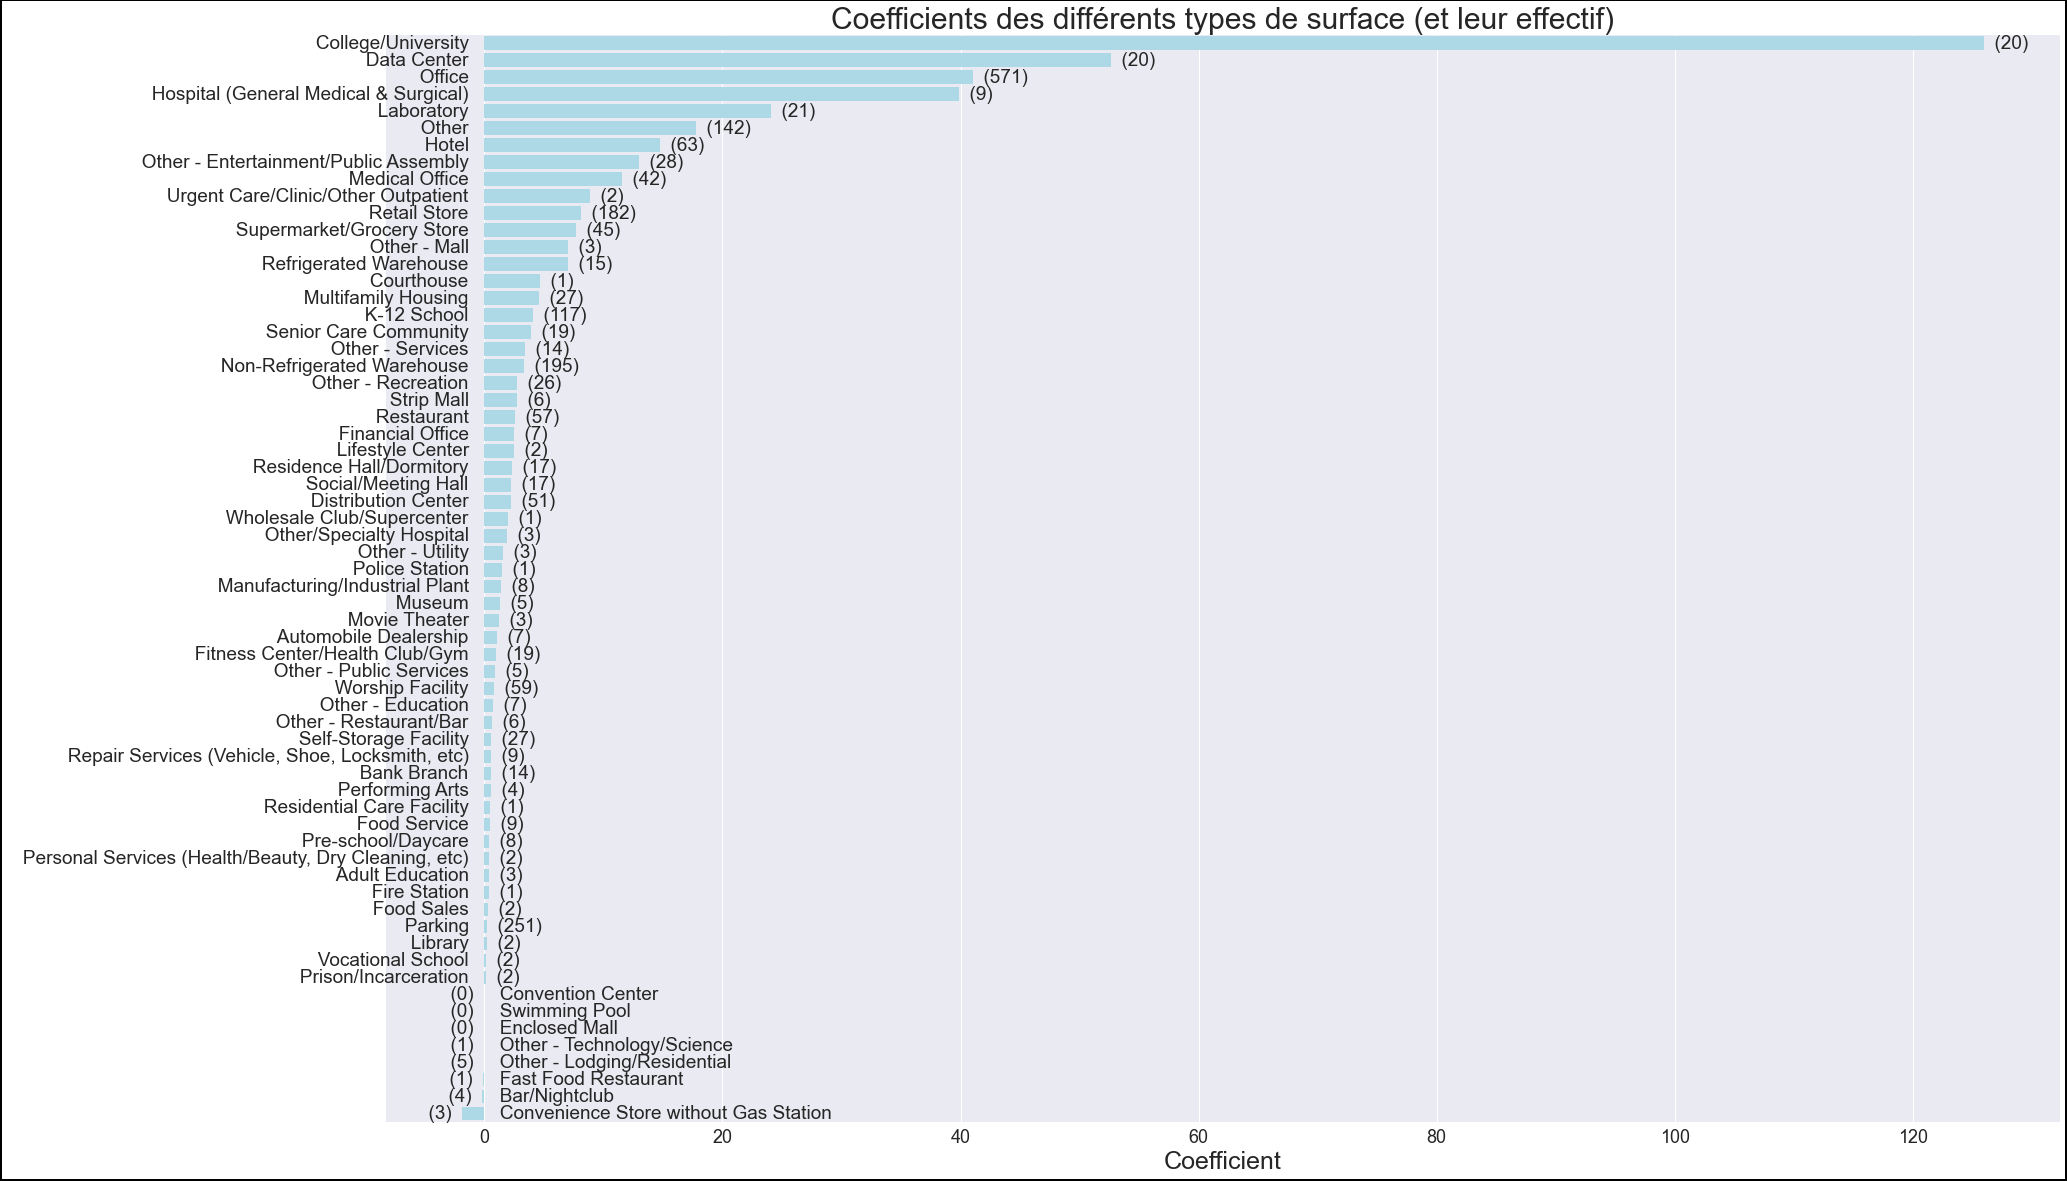

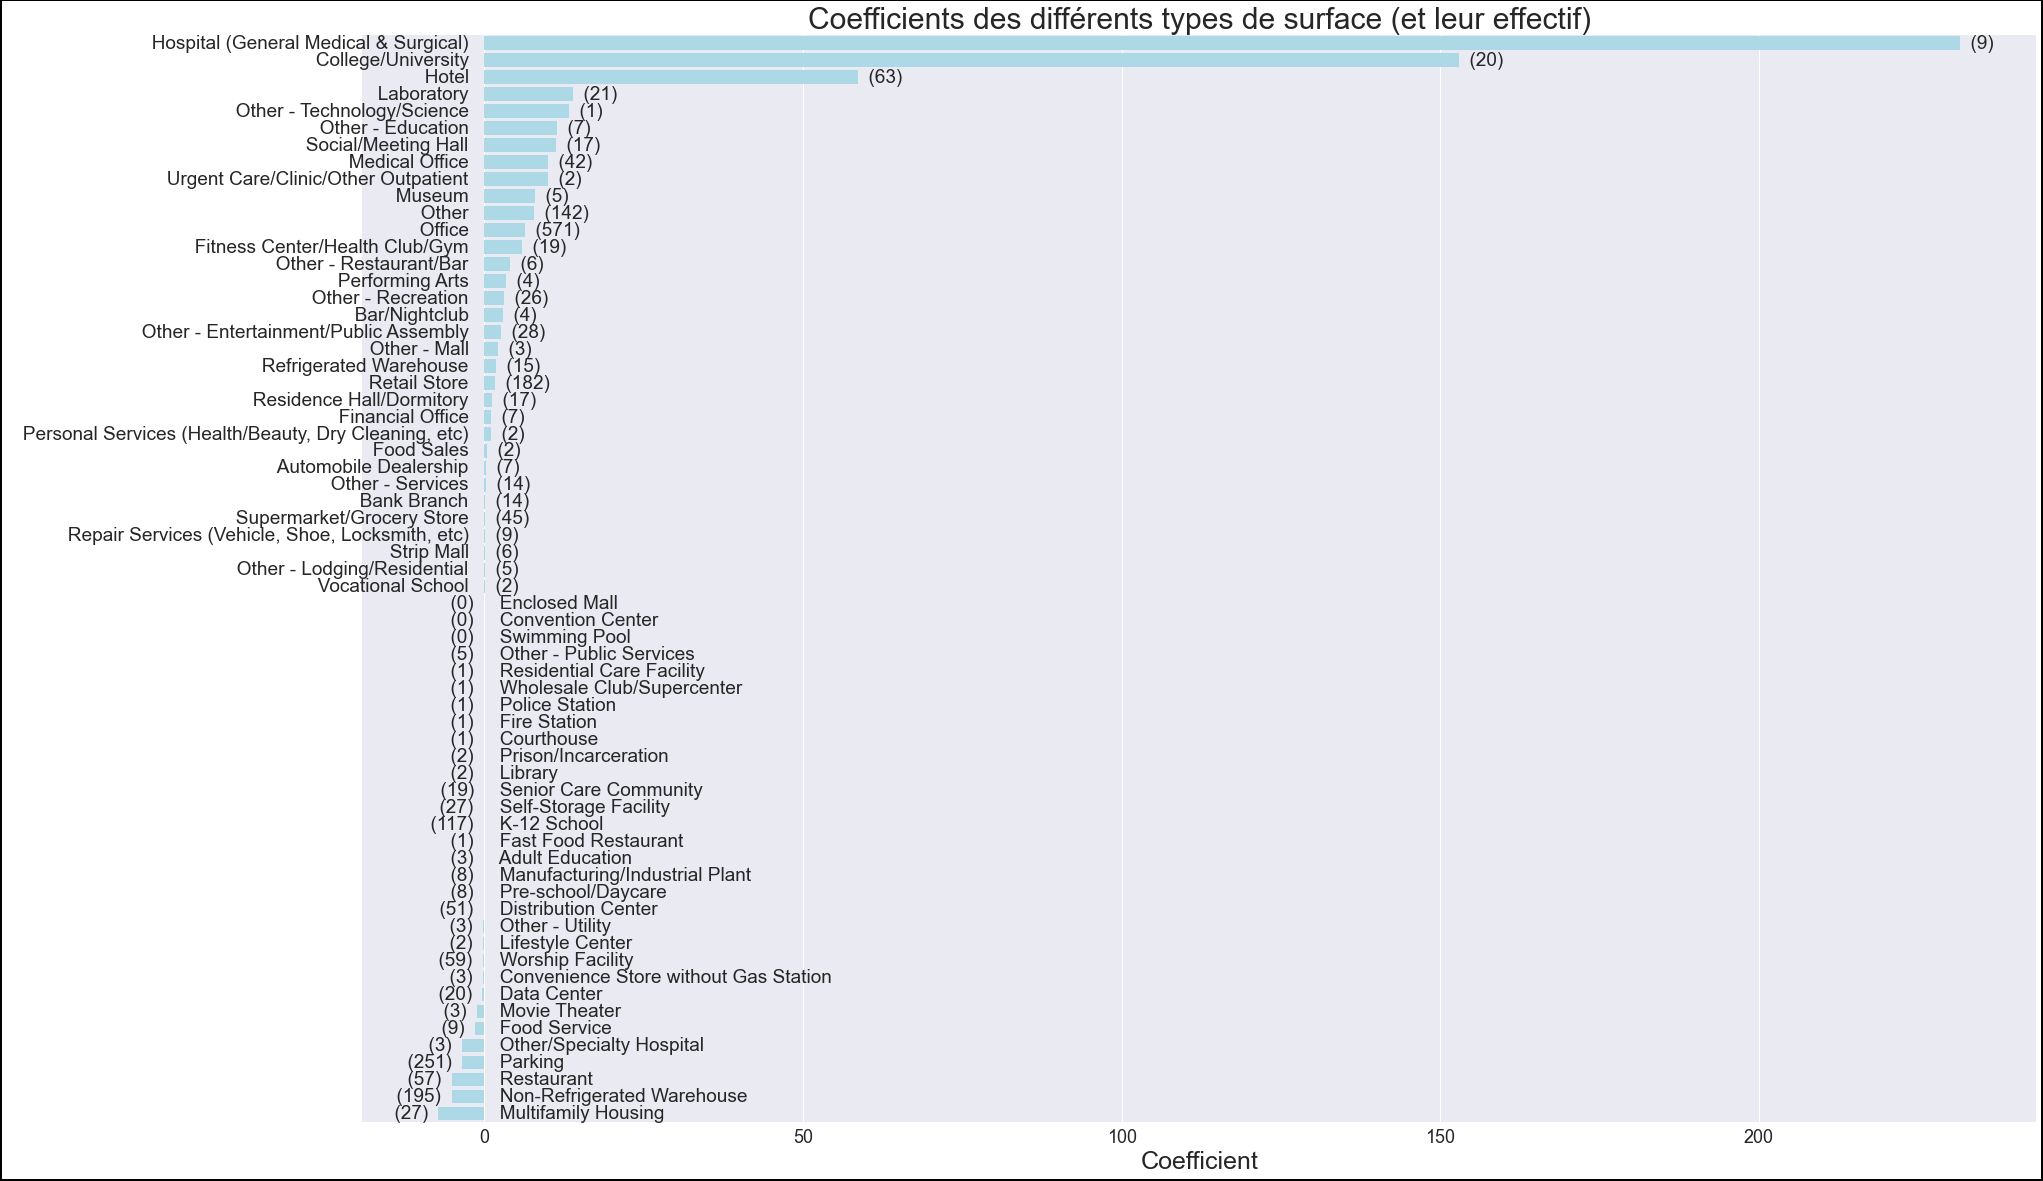

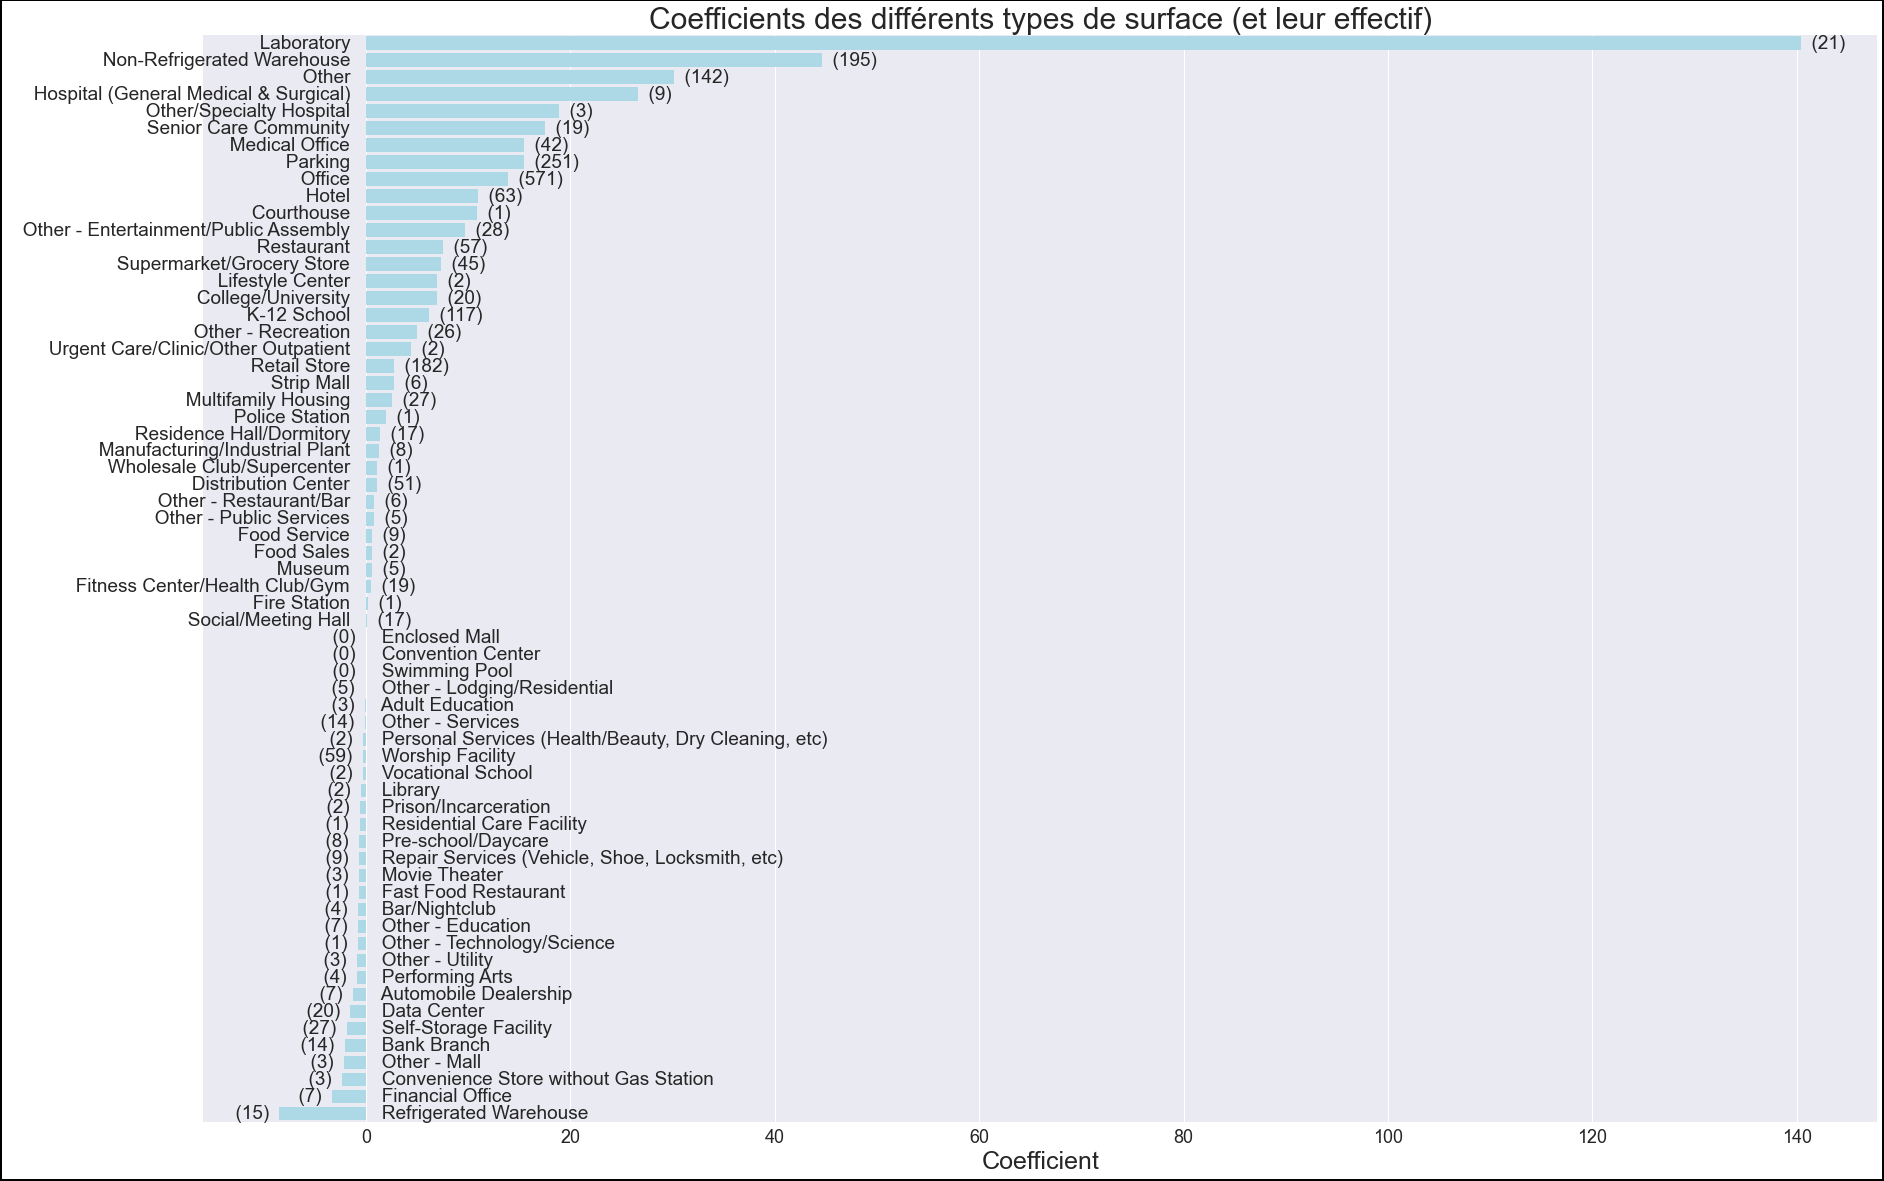

In [91]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS Ridge Elec', ascending=True).loc[:, 'Coef SS Ridge Elec'], effectif_array=df_coefs.sort_values(by='Coef SS Ridge Elec', ascending=True).iloc[:, 0])
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS Ridge Steam', ascending=True).loc[:, 'Coef SS Ridge Steam'], effectif_array=df_coefs.sort_values(by='Coef SS Ridge Steam', ascending=True).iloc[:, 0])
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS Ridge Gas', ascending=True).loc[:, 'Coef SS Ridge Gas'], effectif_array=df_coefs.sort_values(by='Coef SS Ridge Gas', ascending=True).iloc[:, 0])

#### Somme des émissions

In [92]:
    df = pd.DataFrame() 
    df["TotalGHGEmissions"] = y_test_GHG.iloc[:, 3]
    df["GHGEmissions_elec"] = y_test_GHG.iloc[:, 0]
    df["Prédiction_GHGEmissions_elec"] = GHG_predictions_elec
    df["GHGEmissions_steam"] = y_test_GHG.iloc[:, 1]
    df["Prédiction_GHGEmissions_steam"] = GHG_predictions_steam
    df["GHGEmissions_gas"] = y_test_GHG.iloc[:, 2]
    df["Prédiction_GHGEmissions_gas"] = GHG_predictions_gas
    df["Prédiction_TotalGHGEmissions"] = GHG_predictions_elec + GHG_predictions_steam + GHG_predictions_gas
    
    print("R² (généralisation sur y_test) = ", arrondi(r2_score(df['TotalGHGEmissions'], df["Prédiction_TotalGHGEmissions"])))
    display(df)

R² (généralisation sur y_test) =  0.894


,TotalGHGEmissions,GHGEmissions_elec,Prédiction_GHGEmissions_elec,GHGEmissions_steam,Prédiction_GHGEmissions_steam,GHGEmissions_gas,Prédiction_GHGEmissions_gas,Prédiction_TotalGHGEmissions
3022,55.73,4.597332,3.089513,0.0,0.248135,51.133299,64.537061,67.874709
2144,6.30,6.299006,5.715153,0.0,1.350681,0.000000,60.332995,67.398828
1158,60.88,8.677317,5.720113,0.0,-1.780270,52.204315,84.702353,88.642196
308,456.22,373.018665,442.925717,0.0,-8.595443,83.201807,111.523154,545.853428
436,49.74,45.907907,65.367550,0.0,2.289065,3.836029,116.094160,183.750775
...,...,...,...,...,...,...,...,...
596,131.64,14.983042,9.402624,0.0,-3.841172,116.656168,106.062838,111.624290
1878,13.91,13.907839,10.309183,0.0,0.437992,0.000000,68.891191,79.638366
235,298.61,60.923358,64.217882,0.0,12.046115,237.691203,100.944653,177.208651
3109,29.18,5.988545,8.806530,0.0,0.157911,23.191915,45.155571,54.120013


C'est moins bien que pour le calcul direct de 'Prédiction_TotalGHGEmissions' (sans passer par elec/steam/gas).

## Régression LASSO (variables recalibrées par StandardScaler)

### Alpha unique pour les 3 énergies

LassoCV ne permet pas de régulariser un modèle avec plus d'une colonne dans y_test.  
MultiTaskLassoCV est la solution alternative proposée par sklearn, mais elle ne me satisfait pas, car elle ne permet pas d'utiliser le scorer que j'ai mis au point.

### Alpha différent pour chacune des 3 énergies

#### Energie = Elec

In [93]:
lasso_ss_elec = LassoCV(alphas=np.logspace(-9, 0, 100), cv=5, random_state=0)
lasso_ss_elec.fit(X_train_GHG_ss, y_train_GHG.iloc[:,0])

LassoCV(alphas=array([1.00000000e-09, 1.23284674e-09, 1.51991108e-09, 1.87381742e-09, 2.31012970e-09, 2.84803587e-09, 3.51119173e-09, 4.32876128e-09, 5.33669923e-09,
       6.57933225e-09, 8.11130831e-09, 1.00000000e-08, 1.23284674e-08, 1.51991108e-08, 1.87381742e-08, 2.31012970e-08, 2.84803587e-08, 3.51119173e-08,
       4.32876128e-08, 5.33669923e-08, 6.57933225e-08, 8.11130831e-0...
       3.51119173e-03, 4.32876128e-03, 5.33669923e-03, 6.57933225e-03, 8.11130831e-03, 1.00000000e-02, 1.23284674e-02, 1.51991108e-02, 1.87381742e-02,
       2.31012970e-02, 2.84803587e-02, 3.51119173e-02, 4.32876128e-02, 5.33669923e-02, 6.57933225e-02, 8.11130831e-02, 1.00000000e-01, 1.23284674e-01,
       1.51991108e-01, 1.87381742e-01, 2.31012970e-01, 2.84803587e-01, 3.51119173e-01, 4.32876128e-01, 5.33669923e-01, 6.57933225e-01, 8.11130831e-01,
       1.00000000e+00]),
        cv=5, random_state=0)

In [94]:
lasso_ss_elec.alpha_

0.0028480358684358047

In [95]:
arrondi(lasso_ss_elec.intercept_)

41.5

In [96]:
# calcul des R² pour chaque alpha
# baseline_R2 = 0
liste_alpha = np.logspace(-6, 0, 300)   # 300 valeurs alpha
liste_R2 = []
# liste_baseline = []
for alpha in liste_alpha:  
    lasso_ss = Lasso(alpha=alpha, random_state=0) 
    scores = cross_val_score(lasso_ss, X_train_GHG_ss, y_train_GHG.iloc[:,0], 
                             scoring="r2", cv=5)
    liste_R2.append(scores.mean())
#     liste_baseline.append(baseline_R2)

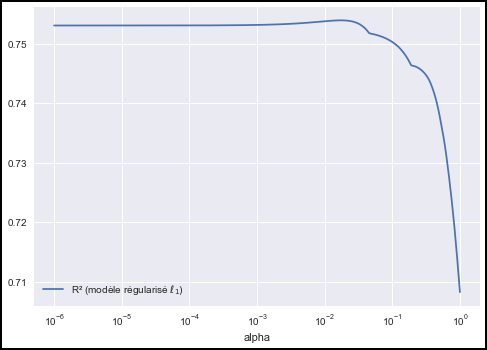

In [97]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
# plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_1$'+')', 'R² (sans régularisation)']);

In [98]:
indice_du_maxi = liste_R2.index(max(liste_R2))
print("Valeur optimale de alpha =", liste_alpha[indice_du_maxi])
print("Valeur optimale de R² =", arrondi(liste_R2[indice_du_maxi]))

Valeur optimale de alpha = 0.01714406135851972
Valeur optimale de R² = 0.754


In [99]:
lasso_optimum = Lasso(alpha=liste_alpha[indice_du_maxi]) 
lasso_optimum.fit(X_train_GHG_ss, y_train_GHG.iloc[:,0])

Lasso(alpha=0.01714406135851972)

In [100]:
arrondi(float(lasso_optimum.intercept_))

41.5

In [101]:
lasso_optimum.coef_

array([ 4.10084701e+01,  3.32881726e+00,  4.02881384e+00,  8.09609009e+00,  1.77057259e+01,  1.47359553e+01,  8.09736003e-01,  2.16640262e+00,  7.63772838e+00,
        1.15322448e+01,  2.39106744e-01,  5.25623238e-01,  2.71064772e+00,  1.25951619e+02,  3.87460334e+00,  1.29566673e+01,  2.32468433e+00,  2.40878500e+01,
        6.98223420e+00,  4.55131300e+00,  2.53762841e+00,  2.18070256e+00,  3.98281696e+01,  1.34373985e+00,  1.00618134e+00,  1.28978700e+00,  5.26988316e-01,
        2.68080873e+00,  9.74937166e-01,  6.83186406e-01, -5.44457947e-02,  3.41384017e+00,  2.49569671e+00,  5.19460445e-01,  6.99810656e+00,  5.02601903e-01,
        5.26523766e+01,  8.80599397e+00,  3.93051161e-01,  1.88762920e+00,  1.54772636e+00,  1.31720553e-01,  5.87017775e-01,  2.46454551e+00,  8.65417379e-01,
        3.60194232e-01,  1.88667701e-01,  3.38695340e-01,  4.49757669e-01,  1.42297089e+00,  1.98419130e+00,  4.20291226e-01,  3.86111636e-01,  4.67009760e+00,
        0.00000000e+00, -2.15703426e-01,

##### Prédiction sur y_test

In [102]:
GHG_predictions_elec = lasso_optimum.predict(X_test_GHG_ss)
print("R² = ", arrondi(lasso_optimum.score(X_test_GHG_ss, y_test_GHG.iloc[:,0])))
GHG_predictions_elec

R² =  0.858


array([ 3.15191435e+00,  5.81079277e+00,  5.80641660e+00,  4.42925113e+02,  6.54609270e+01,  3.84583981e+00,  4.00873373e+00,  1.63922831e+00,  1.44283719e+01,
        1.01431796e+01,  1.85407074e+00,  9.66249385e+01,  1.28667337e+01,  1.26554020e+01,  1.30919708e+00,  1.05659663e+01,  6.28216285e+01,  2.86339619e+01,
        1.60977891e+01,  9.34528735e+00,  2.32942610e+01,  1.25199604e+02,  5.75409474e+01,  1.77716920e+01,  1.01176038e+01,  1.04952395e+01,  7.66195154e+01,
        7.12417445e+00,  7.62991822e+00,  1.94328690e+01,  2.00260652e+01,  7.99485547e+00,  2.20788944e+00,  1.82404860e+01,  1.17351174e+00,  1.98329363e+01,
        3.13320624e+01,  1.85367735e+01,  2.52854607e+00,  9.37091677e+00,  4.24400361e-01,  8.49742585e+00,  1.11006546e+01,  5.82075494e+01,  1.02120836e+01,
        4.95716736e+00,  2.82072038e+01,  1.73501454e+01,  1.54845660e+00,  5.70567383e+00,  2.25485553e+01,  2.75702268e+01,  7.33482222e+01,  2.41072708e+00,
        4.86896089e+01,  2.53411672e+01,

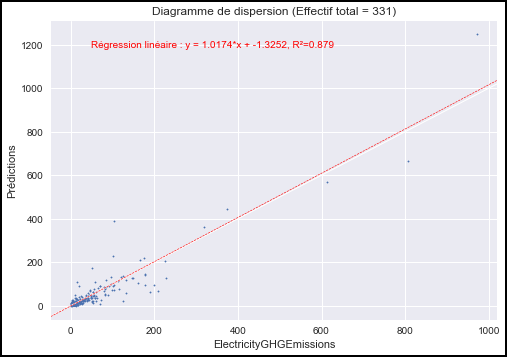

In [103]:
ser_predictions = pd.Series(np.squeeze(GHG_predictions_elec), name='Prédictions')
scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, droite_identite=True)

##### Analyse des coefs du régresseur

In [104]:
df_coefs['Coef SS Lasso Elec'] = lasso_optimum.coef_.T

In [105]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef SS Lasso Elec', ascending=False))

,Effectif,Coef NR LR Elec,Coef NR LR Steam,Coef NR LR Gas,Coef SS Ridge Elec,Coef SS Ridge Steam,Coef SS Ridge Gas,Coef SS Lasso Elec
College/University,20,4.8e-04,6.8e-04,8.1e-05,1.3e+02,1.5e+02,7.0e+00,1.3e+02
Data Center,20,7.5e-03,-6.5e-05,3.9e-05,5.3e+01,-3.3e-01,-1.5e+00,5.3e+01
Office,571,3.4e-04,2.0e-04,8.7e-05,4.1e+01,6.3e+00,1.4e+01,4.1e+01
Hospital (General Medical & Surgical),9,7.6e-04,5.2e-03,1.4e-03,4.0e+01,2.3e+02,2.7e+01,4.0e+01
Laboratory,21,1.1e-03,7.6e-04,1.7e-02,2.4e+01,1.4e+01,1.4e+02,2.4e+01
Other,142,6.2e-04,3.9e-04,3.1e-03,1.8e+01,7.8e+00,3.0e+01,1.8e+01
Hotel,63,3.6e-04,1.8e-03,8.8e-04,1.5e+01,5.9e+01,1.1e+01,1.5e+01
Other - Entertainment/Public Assembly,28,2.4e-04,6.4e-05,5.3e-04,1.3e+01,2.7e+00,9.7e+00,1.3e+01
Medical Office,42,5.2e-04,7.7e-04,1.6e-03,1.2e+01,1.0e+01,1.6e+01,1.2e+01
Urgent Care/Clinic/Other Outpatient,2,2.0e-03,2.7e-03,3.1e-03,8.8e+00,1.0e+01,4.4e+00,8.8e+00


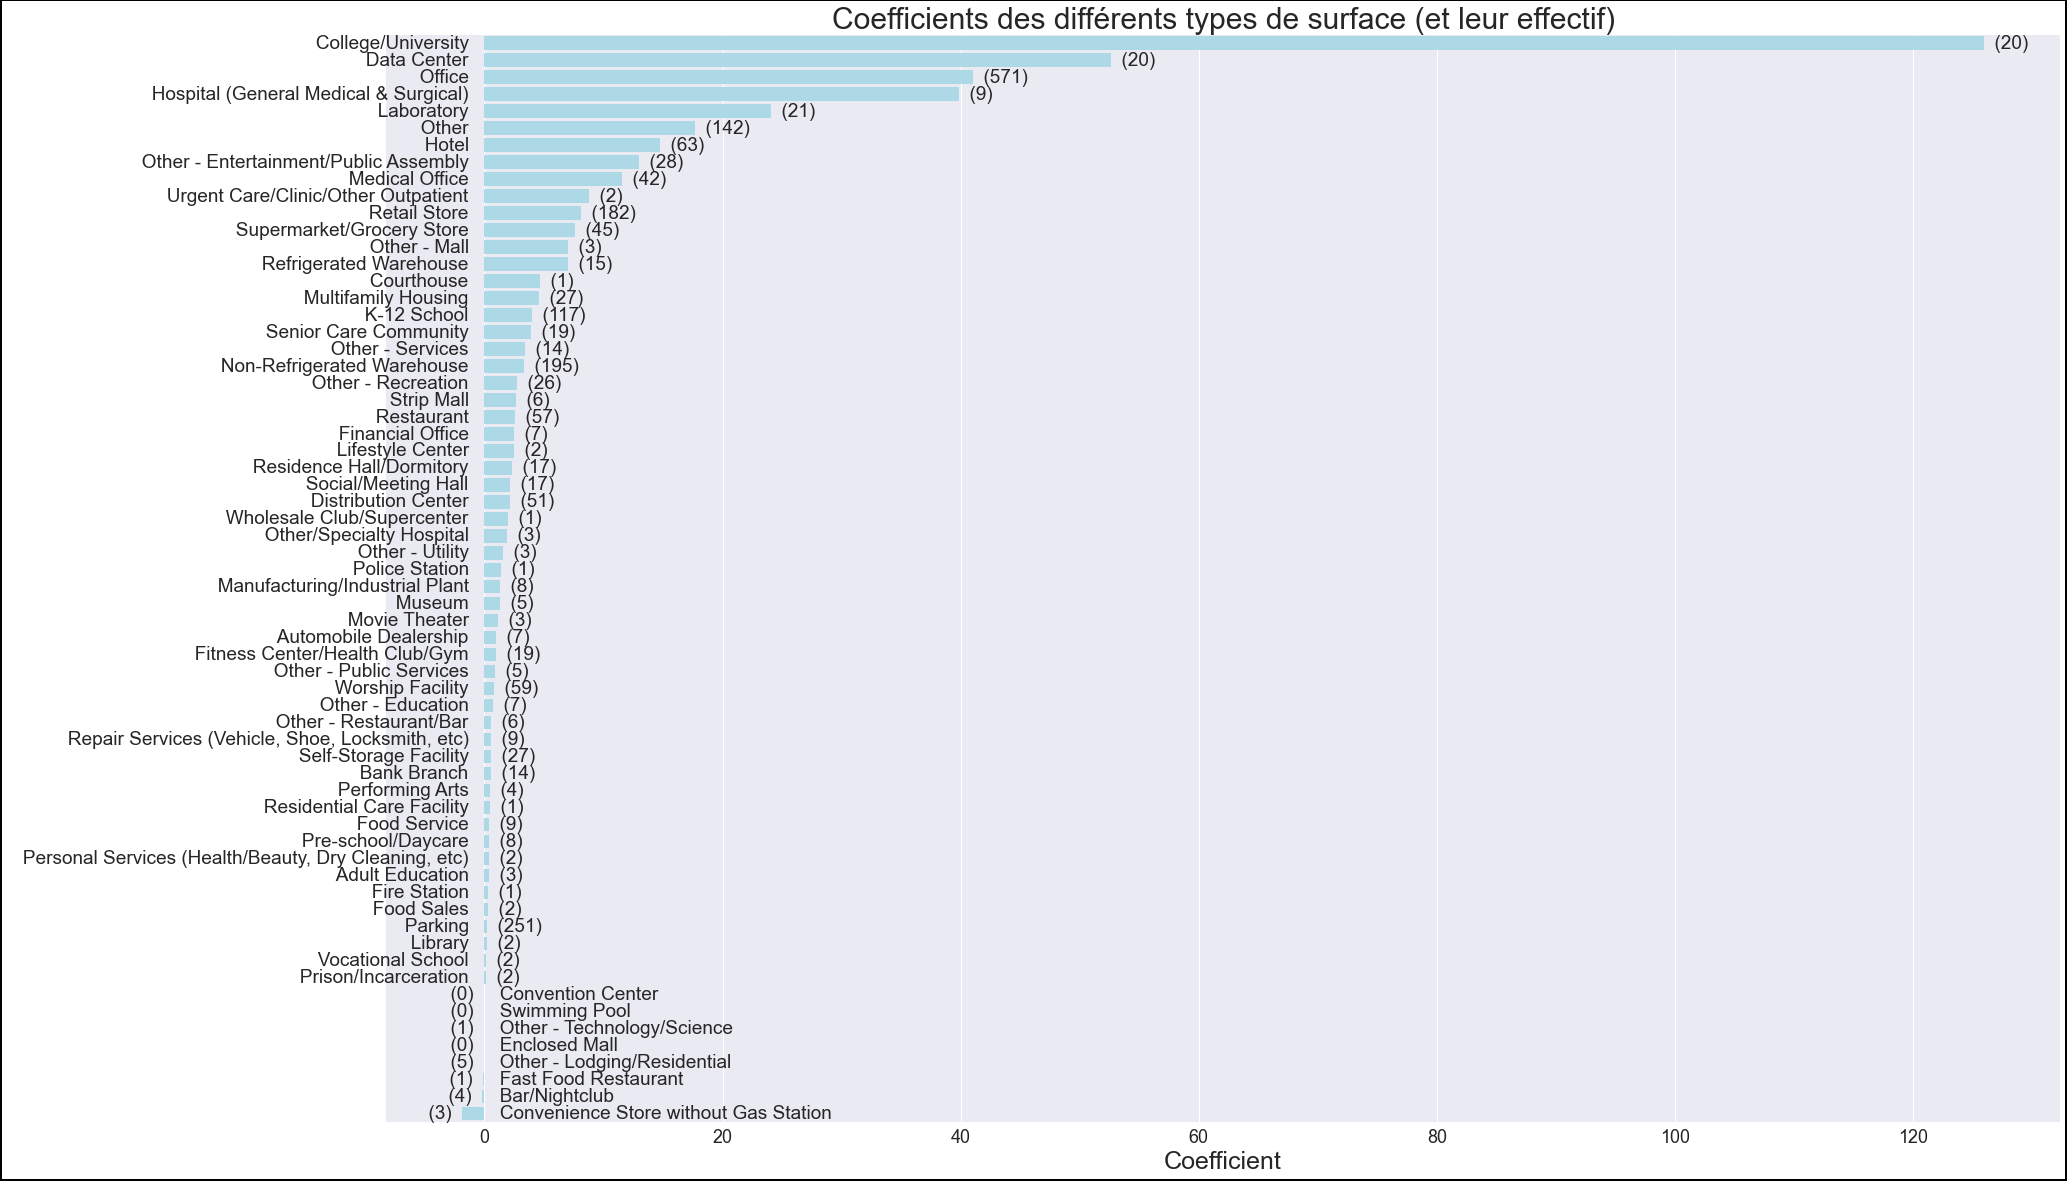

In [106]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS Lasso Elec', ascending=True).loc[:, 'Coef SS Lasso Elec'], effectif_array=df_coefs.sort_values(by='Coef SS Lasso Elec', ascending=True).iloc[:, 0])

#### Energie = Steam

In [107]:
lasso_ss_steam = LassoCV(alphas=np.logspace(-6, 6, 100), cv=5, random_state=0)
lasso_ss_steam.fit(X_train_GHG_ss, y_train_GHG.iloc[:,1])

LassoCV(alphas=array([1.00000000e-06, 1.32194115e-06, 1.74752840e-06, 2.31012970e-06, 3.05385551e-06, 4.03701726e-06, 5.33669923e-06, 7.05480231e-06, 9.32603347e-06,
       1.23284674e-05, 1.62975083e-05, 2.15443469e-05, 2.84803587e-05, 3.76493581e-05, 4.97702356e-05, 6.57933225e-05, 8.69749003e-05, 1.14975700e-04,
       1.51991108e-04, 2.00923300e-04, 2.65608778e-04, 3.51119173e-0...
       5.33669923e+02, 7.05480231e+02, 9.32603347e+02, 1.23284674e+03, 1.62975083e+03, 2.15443469e+03, 2.84803587e+03, 3.76493581e+03, 4.97702356e+03,
       6.57933225e+03, 8.69749003e+03, 1.14975700e+04, 1.51991108e+04, 2.00923300e+04, 2.65608778e+04, 3.51119173e+04, 4.64158883e+04, 6.13590727e+04,
       8.11130831e+04, 1.07226722e+05, 1.41747416e+05, 1.87381742e+05, 2.47707636e+05, 3.27454916e+05, 4.32876128e+05, 5.72236766e+05, 7.56463328e+05,
       1.00000000e+06]),
        cv=5, random_state=0)

In [108]:
lasso_ss_steam.alpha_

0.00572236765935022

In [109]:
arrondi(lasso_ss_steam.intercept_)

36.7

In [110]:
# calcul des R² pour chaque alpha
# baseline_R2 = 0
liste_alpha = np.logspace(-5, 4, 300)   # 300 valeurs alpha
liste_R2 = []
# liste_baseline = []
for alpha in liste_alpha:  
    lasso_ss = Lasso(alpha=alpha, random_state=0) 
    scores = cross_val_score(lasso_ss, X_train_GHG_ss, y_train_GHG.iloc[:,1], 
                             scoring="r2", cv=5)
    liste_R2.append(scores.mean())
#     liste_baseline.append(baseline_R2)

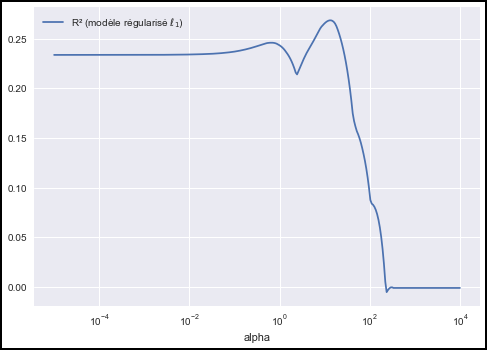

In [111]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
# plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_1$'+')', 'R² (sans régularisation)']);

In [112]:
indice_du_maxi = liste_R2.index(max(liste_R2))
print("Valeur optimale de alpha =", liste_alpha[indice_du_maxi])
print("Valeur optimale de R² =", arrondi(liste_R2[indice_du_maxi]))

Valeur optimale de alpha = 13.818733056536336
Valeur optimale de R² = 0.269


In [113]:
lasso_optimum = Lasso(alpha=liste_alpha[indice_du_maxi]) 
lasso_optimum.fit(X_train_GHG_ss, y_train_GHG.iloc[:,1])

Lasso(alpha=13.818733056536336)

In [114]:
arrondi(float(lasso_optimum.intercept_))

36.7

In [115]:
lasso_optimum.coef_

array([  0.        ,  -0.        ,  -0.        ,   0.        ,   0.        ,  51.12444064,  -0.        ,  -0.        ,  -0.        ,   0.        ,
        -0.        ,  -0.        ,   0.        , 162.94544687,  -0.        ,   0.        ,   0.        ,   1.13595148,  -0.        ,  -0.        ,
        -0.        ,   0.        , 253.31133052,  -0.        ,  -0.        ,   0.        ,  -0.        ,  -0.        ,   0.        ,   0.        ,
        -0.        ,  -0.        ,   0.        ,  -0.        ,  -0.        ,   0.        ,  -0.        ,   0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,   0.        ,  -0.        ,  -0.        ,  -0.        ,  -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,   0.        ,  -0.        ,   0.        ,   0.        ,  -0.        ,  -0.        ,  -0.        ,   0.        ,
        -0.        ,   1.71591013,   0.        ,   0.        ])

##### Prédiction sur y_test

In [116]:
print("R² = ", arrondi(lasso_optimum.score(X_test_GHG_ss, y_test_GHG.iloc[:,1])))
GHG_predictions_steam = lasso_optimum.predict(X_test_GHG_ss)
GHG_predictions_steam

R² =  0.751


array([6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00,
       6.11109660e+00, 6.11109660e+00, 1.32577667e+02, 5.46697820e+01, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 1.09372087e+02,
       6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 9.92364419e+01, 1.43290014e+02, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00,
       6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00,
       6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00,
       6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 6.11109660e+00,
       6.11109660e+00, 6.11109660e+00, 6.11109660e+00, 3.55481379e+02, 6.11109660e+00, 6.11109

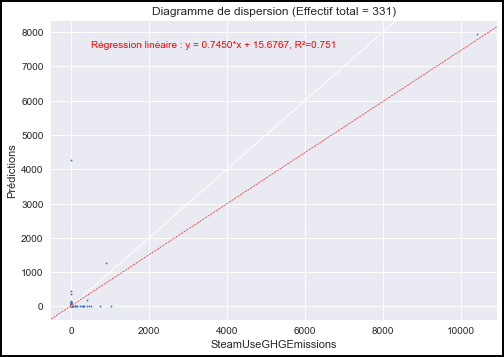

In [117]:
ser_predictions = pd.Series(np.squeeze(GHG_predictions_steam), name='Prédictions')
scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,2], ser_y=ser_predictions, alpha=1, droite_identite=True)

#### Energie = Gas

In [118]:
lasso_ss_gas = LassoCV(alphas=np.logspace(-6, 6, 100), cv=5, random_state=0)
lasso_ss_gas.fit(X_train_GHG_ss, y_train_GHG.iloc[:,2])

LassoCV(alphas=array([1.00000000e-06, 1.32194115e-06, 1.74752840e-06, 2.31012970e-06, 3.05385551e-06, 4.03701726e-06, 5.33669923e-06, 7.05480231e-06, 9.32603347e-06,
       1.23284674e-05, 1.62975083e-05, 2.15443469e-05, 2.84803587e-05, 3.76493581e-05, 4.97702356e-05, 6.57933225e-05, 8.69749003e-05, 1.14975700e-04,
       1.51991108e-04, 2.00923300e-04, 2.65608778e-04, 3.51119173e-0...
       5.33669923e+02, 7.05480231e+02, 9.32603347e+02, 1.23284674e+03, 1.62975083e+03, 2.15443469e+03, 2.84803587e+03, 3.76493581e+03, 4.97702356e+03,
       6.57933225e+03, 8.69749003e+03, 1.14975700e+04, 1.51991108e+04, 2.00923300e+04, 2.65608778e+04, 3.51119173e+04, 4.64158883e+04, 6.13590727e+04,
       8.11130831e+04, 1.07226722e+05, 1.41747416e+05, 1.87381742e+05, 2.47707636e+05, 3.27454916e+05, 4.32876128e+05, 5.72236766e+05, 7.56463328e+05,
       1.00000000e+06]),
        cv=5, random_state=0)

In [119]:
lasso_ss_gas.alpha_

403.70172585965497

In [120]:
arrondi(lasso_ss_gas.intercept_)

106

In [121]:
# calcul des R² pour chaque alpha
# baseline_R2 = 0
liste_alpha = np.logspace(-5, 5, 300)   # 300 valeurs alpha
liste_R2 = []
# liste_baseline = []
for alpha in liste_alpha:  
    lasso_ss = Lasso(alpha=alpha, random_state=0) 
    scores = cross_val_score(lasso_ss, X_train_GHG_ss, y_train_GHG.iloc[:,2], 
                             scoring="r2", cv=5)
    liste_R2.append(scores.mean())
#     liste_baseline.append(baseline_R2)

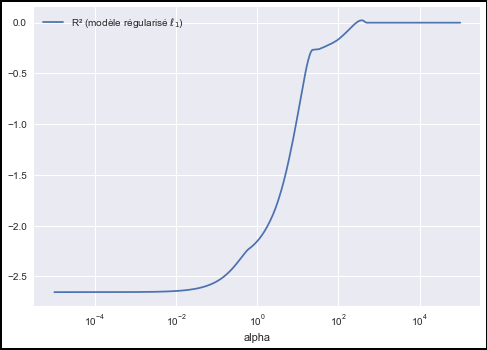

In [122]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
# plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_1$'+')', 'R² (sans régularisation)']);

In [123]:
indice_du_maxi = liste_R2.index(max(liste_R2))
print("Valeur optimale de alpha =", liste_alpha[indice_du_maxi])
print("Valeur optimale de R² =", arrondi(liste_R2[indice_du_maxi]))

Valeur optimale de alpha = 361.8498759642743
Valeur optimale de R² = 0.0216


In [124]:
lasso_optimum = Lasso(alpha=liste_alpha[indice_du_maxi]) 
lasso_optimum.fit(X_train_GHG_ss, y_train_GHG.iloc[:,2])

Lasso(alpha=361.8498759642743)

In [125]:
arrondi(float(lasso_optimum.intercept_))

106

In [126]:
lasso_optimum.coef_

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,  0.       , -0.       , -0.       ,  0.       ,  0.       ,  0.       , -0.       ,
        0.       ,  0.       ,  0.       ,  0.       , -0.       , 20.4451419, -0.       ,  0.       ,  0.       , -0.       ,  0.       ,  0.       ,
       -0.       , -0.       , -0.       ,  0.       , -0.       , -0.       , -0.       , -0.       , -0.       , -0.       , -0.       , -0.       ,
       -0.       ,  0.       , -0.       ,  0.       , -0.       , -0.       ,  0.       ,  0.       ,  0.       , -0.       , -0.       , -0.       ,
       -0.       ,  0.       ,  0.       ,  0.       , -0.       ,  0.       ,  0.       , -0.       ,  0.       ,  0.       , -0.       , -0.       ,
       -0.       , -0.       ,  0.       ,  0.       ])

##### Prédiction sur y_test

In [127]:
GHG_predictions_gas = lasso_optimum.predict(X_test_GHG_ss)
print("R² = ", arrondi(lasso_optimum.score(X_test_GHG_ss, y_test_GHG.iloc[:,2])))

R² =  -0.000278


La prédiction est moins bonne qu'un Dummy Regressor car R² < 0.

#### Somme des émissions

In [128]:
    df = pd.DataFrame() 
    df["TotalGHGEmissions"] = y_test_GHG.iloc[:, 3]
    df["GHGEmissions_elec"] = y_test_GHG.iloc[:, 0]
    df["Prédiction_GHGEmissions_elec"] = GHG_predictions_elec
    df["GHGEmissions_steam"] = y_test_GHG.iloc[:, 1]
    df["Prédiction_GHGEmissions_steam"] = GHG_predictions_steam
    df["GHGEmissions_gas"] = y_test_GHG.iloc[:, 2]
    df["Prédiction_GHGEmissions_gas"] = GHG_predictions_gas
    df["Prédiction_TotalGHGEmissions"] = GHG_predictions_elec + GHG_predictions_steam + GHG_predictions_gas
    
    print("R² (généralisation sur y_test) = ", arrondi(r2_score(df['TotalGHGEmissions'], df["Prédiction_TotalGHGEmissions"])))
    display(df)

R² (généralisation sur y_test) =  0.886


,TotalGHGEmissions,GHGEmissions_elec,Prédiction_GHGEmissions_elec,GHGEmissions_steam,Prédiction_GHGEmissions_steam,GHGEmissions_gas,Prédiction_GHGEmissions_gas,Prédiction_TotalGHGEmissions
3022,55.73,4.597332,3.151914,0.0,6.111097,51.133299,104.458245,113.721256
2144,6.30,6.299006,5.810793,0.0,6.111097,0.000000,104.458245,116.380135
1158,60.88,8.677317,5.806417,0.0,6.111097,52.204315,104.458245,116.375759
308,456.22,373.018665,442.925113,0.0,6.111097,83.201807,104.458245,553.494455
436,49.74,45.907907,65.460927,0.0,6.111097,3.836029,104.458245,176.030269
...,...,...,...,...,...,...,...,...
596,131.64,14.983042,9.478810,0.0,6.111097,116.656168,104.458245,120.048152
1878,13.91,13.907839,10.412736,0.0,6.111097,0.000000,104.458245,120.982078
235,298.61,60.923358,64.250597,0.0,6.111097,237.691203,104.458245,174.819939
3109,29.18,5.988545,8.295776,0.0,6.111097,23.191915,104.458245,118.865118
